# Unraveling Philippine Aviation: A Comprehensive Analysis through Network Science and Scenario Exploration

# Executive Summary

In my years of experience in the aviation industry, I have witnessed a myriad of situations that come with air travel. The commonplace flight delays are something airlines in the Philippines have become adept at handling, both operationally and in customer service. But amidst the usual challenges, I often find myself pondering an unconventional scenario: What if a major airport like the Ninoy Aquino International Airport (NAIA) suddenly ceased operations? While flight disruptions would undoubtedly follow, I can't help but wonder about the broader implications for the other airports across the country. This question isn't just a flight of fancy; it has happened before, with a recent incident marking the beginning of the year, making for a rather memorable New Year's Day. [1]

In this blog, I invite you to join me on an exploration of the captivating world of network science applied to our local airport network, characterized by its hub-and-spoke nature. Together, we will uncover fascinating patterns, from the busiest airports to the shortest routes between any two airports, and delve into the intricate interconnections that shape our aviation landscape. Most notably, we'll embark on an exciting scenario analysis to understand the consequences of shutting down the busiest airport in the Philippines. [8]

This blog is your comprehensive guide to the intriguing realm of airports in the Philippine airspace. Whether you're an aviation professional involved in fleet planning, or simply a frequent traveler or a first-time flyer mapping out your travel itinerary, this wealth of information promises to be an invaluable resource.

# Data Source

The Global Air Transportation Network is a comprehensive dataset that includes air travel data, such as information about airports, airlines, routes, and airplanes. This valuable database contains over 10,000 data points compiled by OpenFlights (https://openflights.org) from a variety of reliable sources. This dataset is maintained and updated regularly by Tyler Woebkenberg (https://data.world/tylerudite).

However, for this discussion, we will focus solely on the Philippine airspace, particularly the airports within this region, and limit our analysis to domestic flights.

# Libraries

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import warnings

import networkx as nx
from mpl_toolkits.basemap import Basemap as Basemap
from networkx.algorithms.community import girvan_newman, modularity


from google.colab import drive
drive.mount('/content/gdrive')

warnings.filterwarnings("ignore")
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Dependencies

In [4]:
# !pip install basemap basemap-data-hires

In [ ]:
# Data Loading

In [6]:
file_path = 'gdrive/My Drive//Colab Notebooks/airport_network/flight_data'
airlines = f'{file_path}/airlines.csv'
airplanes = f'{file_path}/airplanes.csv'
airports = f'{file_path}/airports.csv'
routes = f'{file_path}/routes.csv'

df_airlines = pd.read_csv(airlines)
df_airplanes = pd.read_csv(airlines)
df_airports = pd.read_csv(airports)
df_routes = pd.read_csv(routes)

In [7]:
df_airlines

index  Airline ID                                          Name  \
0         0          -1                                       Unknown   
1         1           1                                Private flight   
2         2           2                                   135 Airways   
3         3           3                                 1Time Airline   
4         4           4  2 Sqn No 1 Elementary Flying Training School   
...     ...         ...                                           ...   
6157   6157       21248                                   GX Airlines   
6158   6158       21251                        Lynx Aviation (L3/SSX)   
6159   6159       21268                               Jetgo Australia   
6160   6160       21270                                  Air Carnival   
6161   6161       21317                                 Svyaz Rossiya   

                  Alias IATA ICAO         Callsign         Country Active  
0                    \N    -  NaN               \N              \N      Y  
1                    \N    -  NaN              NaN             NaN      Y  
2                    \N  NaN  GNL          GENERAL   United States      N  
3                    \N   1T  RNX          NEXTIME    South Africa      Y  
4                    \N  NaN  WYT              NaN  United Kingdom      N  
...                 ...  ...  ...              ...             ...    ...  
6157                NaN  NaN  CBG            SPRAY           China      Y  
6158                NaN  NaN  SSX           Shasta   United States      N  
6159                NaN   JG   \N              NaN       Australia      Y  
6160                NaN   2S   \N              NaN           India      Y  
6161  Russian Commuter    7R  SJM  RussianConnecty          Russia      Y  

[6162 rows x 9 columns]

In [8]:
df_airplanes

index  Airline ID                                          Name  \
0         0          -1                                       Unknown   
1         1           1                                Private flight   
2         2           2                                   135 Airways   
3         3           3                                 1Time Airline   
4         4           4  2 Sqn No 1 Elementary Flying Training School   
...     ...         ...                                           ...   
6157   6157       21248                                   GX Airlines   
6158   6158       21251                        Lynx Aviation (L3/SSX)   
6159   6159       21268                               Jetgo Australia   
6160   6160       21270                                  Air Carnival   
6161   6161       21317                                 Svyaz Rossiya   

                  Alias IATA ICAO         Callsign         Country Active  
0                    \N    -  NaN               \N              \N      Y  
1                    \N    -  NaN              NaN             NaN      Y  
2                    \N  NaN  GNL          GENERAL   United States      N  
3                    \N   1T  RNX          NEXTIME    South Africa      Y  
4                    \N  NaN  WYT              NaN  United Kingdom      N  
...                 ...  ...  ...              ...             ...    ...  
6157                NaN  NaN  CBG            SPRAY           China      Y  
6158                NaN  NaN  SSX           Shasta   United States      N  
6159                NaN   JG   \N              NaN       Australia      Y  
6160                NaN   2S   \N              NaN           India      Y  
6161  Russian Commuter    7R  SJM  RussianConnecty          Russia      Y  

[6162 rows x 9 columns]

In [9]:
df_airports

index  Airport ID                                         Name  \
0         0           1                               Goroka Airport   
1         1           2                               Madang Airport   
2         2           3                 Mount Hagen Kagamuga Airport   
3         3           4                               Nadzab Airport   
4         4           5  Port Moresby Jacksons International Airport   
...     ...         ...                                          ...   
7693   7693       14106                          Rogachyovo Air Base   
7694   7694       14107                        Ulan-Ude East Airport   
7695   7695       14108                         Krechevitsy Air Base   
7696   7696       14109                  Desierto de Atacama Airport   
7697   7697       14110                           Melitopol Air Base   

              City           Country IATA  ICAO   Latitude   Longitude  \
0           Goroka  Papua New Guinea  GKA  AYGA  -6.081690  145.391998   
1           Madang  Papua New Guinea  MAG  AYMD  -5.207080  145.789001   
2      Mount Hagen  Papua New Guinea  HGU  AYMH  -5.826790  144.296005   
3           Nadzab  Papua New Guinea  LAE  AYNZ  -6.569803  146.725977   
4     Port Moresby  Papua New Guinea  POM  AYPY  -9.443380  147.220001   
...            ...               ...  ...   ...        ...         ...   
7693        Belaya            Russia   \N  ULDA  71.616699   52.478298   
7694      Ulan Ude            Russia   \N  XIUW  51.849998  107.737999   
7695      Novgorod            Russia   \N  ULLK  58.625000   31.385000   
7696       Copiapo             Chile  CPO  SCAT -27.261200  -70.779198   
7697     Melitopol           Ukraine   \N  UKDM  46.880001   35.305000   

      Altitude Timezone DST Tz database time zone     Type       Source  
0         5282       10   U  Pacific/Port_Moresby  airport  OurAirports  
1           20       10   U  Pacific/Port_Moresby  airport  OurAirports  
2         5388       10   U  Pacific/Port_Moresby  airport  OurAirports  
3          239       10   U  Pacific/Port_Moresby  airport  OurAirports  
4          146       10   U  Pacific/Port_Moresby  airport  OurAirports  
...        ...      ...  ..                   ...      ...          ...  
7693       272       \N  \N                    \N  airport  OurAirports  
7694      1670       \N  \N                    \N  airport  OurAirports  
7695        85       \N  \N                    \N  airport  OurAirports  
7696       670       \N  \N                    \N  airport  OurAirports  
7697         0       \N  \N                    \N  airport  OurAirports  

[7698 rows x 15 columns]

In [10]:
df_routes

index Airline Airline ID Source airport Source airport ID  \
0          0      2B        410            AER              2965   
1          1      2B        410            ASF              2966   
2          2      2B        410            ASF              2966   
3          3      2B        410            CEK              2968   
4          4      2B        410            CEK              2968   
...      ...     ...        ...            ...               ...   
67658  67658      ZL       4178            WYA              6334   
67659  67659      ZM      19016            DME              4029   
67660  67660      ZM      19016            FRU              2912   
67661  67661      ZM      19016            FRU              2912   
67662  67662      ZM      19016            OSS              2913   

      Destination airport Destination airport ID Codeshare  Stops Equipment  
0                     KZN                   2990       NaN      0       CR2  
1                     KZN                   2990       NaN      0       CR2  
2                     MRV                   2962       NaN      0       CR2  
3                     KZN                   2990       NaN      0       CR2  
4                     OVB                   4078       NaN      0       CR2  
...                   ...                    ...       ...    ...       ...  
67658                 ADL                   3341       NaN      0       SF3  
67659                 FRU                   2912       NaN      0       734  
67660                 DME                   4029       NaN      0       734  
67661                 OSS                   2913       NaN      0       734  
67662                 FRU                   2912       NaN      0       734  

[67663 rows x 10 columns]

# Data Preprocessing

## Cleaning PH Airports

In [11]:
df_airports_ph = df_airports.loc[df_airports['Country'] == 'Philippines']
df_airports_ph

index  Airport ID                                  Name  \
2289   2289        2397    Ninoy Aquino International Airport   
2290   2290        2399                         Awang Airport   
2291   2291        2400                Cagayan De Oro Airport   
2292   2292        2401                      Pagadian Airport   
2293   2293        2402  General Santos International Airport   
...     ...         ...                                   ...   
7584   7584       13583                    Catbalogan Airport   
7585   7585       13584                        Maasin Airport   
7586   7586       13592                      Bantayan Airport   
7587   7587       13593                       Biliran Airport   
7689   7689       14102                  Laguindingan Airport   

                     City      Country IATA  ICAO   Latitude   Longitude  \
2289               Manila  Philippines  MNL  RPLL  14.508600  121.019997   
2290             Cotabato  Philippines  CBO  RPMC   7.165240  124.209999   
2291                Ladag  Philippines   \N  RPML   8.415620  124.611000   
2292             Pagadian  Philippines  PAG  RPMP   7.830731  123.461180   
2293              Romblon  Philippines  GES  RPMR   6.058000  125.096001   
...                   ...          ...  ...   ...        ...         ...   
7584      Catbalogan City  Philippines   \N  RPVY  11.810000  124.830000   
7585               Maasin  Philippines   \N  RPSM  10.187300  124.781998   
7586             Bantayan  Philippines   \N  RPSB  11.162400  123.784800   
7587              Biliran  Philippines   \N  RPVQ  11.515918  124.428985   
7689  Cagayan de Oro City  Philippines  CGY  RPMY   8.612203  124.456496   

      Altitude Timezone DST Tz database time zone     Type       Source  
2289        75        8   N           Asia/Manila  airport  OurAirports  
2290       189        8   N           Asia/Manila  airport  OurAirports  
2291       601        8   N           Asia/Manila  airport  OurAirports  
2292         5        8   N           Asia/Manila  airport  OurAirports  
2293       505        8   N           Asia/Manila  airport  OurAirports  
...        ...      ...  ..                   ...      ...          ...  
7584         0        8   N                    \N  airport  OurAirports  
7585       328        8   N                    \N  airport  OurAirports  
7586        60        8   N                    \N  airport  OurAirports  
7587         0        8   N                    \N  airport  OurAirports  
7689       190       \N  \N                    \N  airport  OurAirports  

[71 rows x 15 columns]

### Checking Null Values

In [12]:
df_airports_ph.isna().sum()

index                    0
Airport ID               0
Name                     0
City                     2
Country                  0
IATA                     0
ICAO                     0
Latitude                 0
Longitude                0
Altitude                 0
Timezone                 0
DST                      0
Tz database time zone    0
Type                     0
Source                   0
dtype: int64

In [13]:
df_airports_ph.loc[df_airports_ph['City'].isna()]

index  Airport ID                   Name City      Country IATA  ICAO  \
7164   7164       11927         Bislig Airport  NaN  Philippines  BPH  RPMF   
7165   7165       11928  Mati National Airport  NaN  Philippines  MXI  RPMQ   

      Latitude   Longitude  Altitude Timezone DST Tz database time zone  \
7164  8.195950  126.321999        12       \N  \N                    \N   
7165  6.949091  126.273680       156       \N  \N                    \N   

         Type       Source  
7164  airport  OurAirports  
7165  airport  OurAirports

In [14]:
df_airports_ph.at[7164, 'City'] = 'Bislig'
df_airports_ph.at[7165, 'City'] = 'Mati'

In [15]:
df_airports_ph.loc[df_airports_ph['IATA'] == r'\N', 'IATA'] = np.nan

In [16]:
df_airports_ph.loc[df_airports_ph['IATA'].isna()]

index  Airport ID                       Name                 City  \
2291   2291        2400     Cagayan De Oro Airport                Ladag   
2297   2297        2407              Basa Air Base        Floridablanca   
2298   2298        2408           Lingayen Airport             Lingayen   
2300   2300        2410          Fernando Air Base                 Lipa   
2302   2302        2414              Vigan Airport                Vigan   
2304   2304        2421            Bagabag Airport              Bagabag   
2309   2309        2428             Guiuan Airport               Guiuan   
4656   4656        6011      Rajah Buayan Air Base  General Santos City   
5667   5667        7559           Borongan Airport             Borongan   
6965   6965       11700           Siquijor Airport             Siquijor   
7582   7582       13580  Palanan Community Airport              Palanan   
7583   7583       13581            Itbayat Airport              Itbayat   
7584   7584       13583         Catbalogan Airport      Catbalogan City   
7585   7585       13584             Maasin Airport               Maasin   
7586   7586       13592           Bantayan Airport             Bantayan   
7587   7587       13593            Biliran Airport              Biliran   

          Country IATA  ICAO   Latitude   Longitude  Altitude Timezone DST  \
2291  Philippines  NaN  RPML   8.415620  124.611000       601        8   N   
2297  Philippines  NaN  RPUF  14.987240  120.492554       151        8   N   
2298  Philippines  NaN  RPUG  16.034800  120.240997         7        8   N   
2300  Philippines  NaN  RPUL  13.955000  121.125000      1220        8   N   
2302  Philippines  NaN  RPUQ  17.555300  120.356003        16        8   N   
2304  Philippines  NaN  RPUZ  16.619200  121.251999       820        8   N   
2309  Philippines  NaN  RPVG  11.035500  125.741997         7        8   N   
4656  Philippines  NaN  RPMB   6.106440  125.235001        28        8   N   
5667  Philippines  NaN  RPVW  11.674300  125.478996         7        8   N   
6965  Philippines  NaN  RPVZ   9.214203  123.472252         0        8   N   
7582  Philippines  NaN  RPLN  17.065667  122.427671        52        8   N   
7583  Philippines  NaN  RPLT  20.722521  121.809969       328        8   N   
7584  Philippines  NaN  RPVY  11.810000  124.830000         0        8   N   
7585  Philippines  NaN  RPSM  10.187300  124.781998       328        8   N   
7586  Philippines  NaN  RPSB  11.162400  123.784800        60        8   N   
7587  Philippines  NaN  RPVQ  11.515918  124.428985         0        8   N   

     Tz database time zone     Type       Source  
2291           Asia/Manila  airport  OurAirports  
2297           Asia/Manila  airport  OurAirports  
2298           Asia/Manila  airport  OurAirports  
2300           Asia/Manila  airport  OurAirports  
2302           Asia/Manila  airport  OurAirports  
2304           Asia/Manila  airport  OurAirports  
2309           Asia/Manila  airport  OurAirports  
4656           Asia/Manila  airport  OurAirports  
5667           Asia/Manila  airport  OurAirports  
6965                    \N  airport  OurAirports  
7582                    \N  airport  OurAirports  
7583                    \N  airport  OurAirports  
7584                    \N  airport  OurAirports  
7585                    \N  airport  OurAirports  
7586                    \N  airport  OurAirports  
7587                    \N  airport  OurAirports

In [17]:
df_airports_ph = df_airports_ph.dropna(subset=['IATA'])

In [18]:
df_airports_ph.isna().sum()

index                    0
Airport ID               0
Name                     0
City                     0
Country                  0
IATA                     0
ICAO                     0
Latitude                 0
Longitude                0
Altitude                 0
Timezone                 0
DST                      0
Tz database time zone    0
Type                     0
Source                   0
dtype: int64

In [19]:
df_airports_ph = df_airports_ph[['Name', 'City', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude']]
df_airports_ph

Name                 City IATA  \
2289        Ninoy Aquino International Airport               Manila  MNL   
2290                             Awang Airport             Cotabato  CBO   
2292                          Pagadian Airport             Pagadian  PAG   
2293      General Santos International Airport              Romblon  GES   
2294           Zamboanga International Airport            Zamboanga  ZAM   
2295                            Loakan Airport               Baguio  BAG   
2296                              Daet Airport                 Daet  DTE   
2299                          San Jose Airport             San Jose  SJI   
2301                          Mamburao Airport             Mamburao  MBO   
2303                 Dr.Juan C. Angara Airport                Baler  BQA   
2305               Daniel Z. Romualdez Airport             Tacloban  TAC   
2306                     Bacolod-Silay Airport              Bacolod  BCD   
2307                           Sibulan Airport            Dumaguete  DGT   
2308                Godofredo P. Ramos Airport             Caticlan  MPH   
2310              Iloilo International Airport               Iloilo  ILO   
2311              Kalibo International Airport               Kalibo  KLO   
2312                   Puerto Princesa Airport      Puerto Princesa  PPS   
2313                     Evelio Javier Airport             San Jose  EUQ   
3783                        Tagbilaran Airport           Tagbilaran  TAG   
3867    Francisco Bangoy International Airport                Davao  DVO   
3912  Diosdado Macapagal International Airport         Angeles City  CRK   
3965                Francisco B. Reyes Airport             Busuanga  USU   
3966                           Bancasi Airport               Butuan  BXU   
3967                           Dipolog Airport              Dipolog  DPL   
3968               Laoag International Airport                Laoag  LAO   
3969        Legazpi City International Airport              Legazpi  LGP   
3970                              Labo Airport               Ozamis  OZC   
3971         Mactan Cebu International Airport                 Cebu  CEB   
4654           Subic Bay International Airport        Olongapo City  SFS   
4655                              Cuyo Airport                 Cuyo  CYU   
4657                          Camiguin Airport             Camiguin  CGM   
4658                              Jolo Airport                 Jolo  JOL   
4659                       Sanga Sanga Airport          Sanga Sanga  TWT   
4660                           Surigao Airport        Sangley Point  SUG   
4661                            Tandag Airport               Tandag  TDG   
4662                              Naga Airport                 Naga  WNP   
4663                             Basco Airport                Basco  BSO   
4664                      San Fernando Airport         San Fernando  SFE   
4665                        Tuguegarao Airport           Tuguegarao  TUG   
4666                             Virac Airport                Virac  VRC   
4667                          Calbayog Airport        Calbayog City  CYP   
4668                 Catarman National Airport             Catarman  CRM   
4669                Moises R. Espinosa Airport              Masbate  MBT   
4670                             Roxas Airport           Roxas City  RXS   
5111                             Ormoc Airport           Ormoc City  OMC   
5118                           Cauayan Airport              Cauayan  CYZ   
5130                            Tugdan Airport              Romblon  TBH   
5174                        Marinduque Airport                Gasan  MRQ   
5288                           Siargao Airport              Siargao  IAO   
5668                            Lubang Airport               Lubang  LBX   
6151               Cesar Lim Rodriguez Airport               Taytay  RZP   
7163                      Allah Valley Airport             Surallah  AAV   
7164          

In [20]:
ph_airports_list = df_airports_ph['IATA'].unique()

## Cleaning PH Airlines

In [21]:
df_airlines_ph = df_airlines.loc[df_airlines['Country'] == 'Philippines']
df_airlines_ph = df_airlines_ph[['Name', 'IATA', 'ICAO']]
df_airlines_ph = df_airlines_ph.dropna()
df_airlines_ph

Name IATA ICAO
372             Asia Overnight Express   OE  AOT
897                    Air Philippines   2P  GAP
1199                      Asian Spirit   6K  RIT
1682                      Cebu Pacific   5J  CEB
3233      Laoag International Airlines   L7  LPN
3852  Pacific East Asia Cargo Airlines   Q8  PEC
3946               Philippine Airlines   PR  PAL
4467         South East Asian Airlines   DG  SRQ
5552                          Zest Air   Z2   \N
5671         Spirit of Manila Airlines   SM  MNP

In [22]:
ph_airlines_list = df_airlines_ph['IATA'].unique()

## Cleaning PH Airplanes

In [23]:
df_airplanes_ph = df_airplanes.loc[df_airplanes['Country'] == 'Philippines']
df_airplanes_ph = df_airplanes_ph[['Name', 'IATA', 'ICAO']]
df_airplanes_ph = df_airplanes_ph.dropna()
df_airplanes_ph

Name IATA ICAO
372             Asia Overnight Express   OE  AOT
897                    Air Philippines   2P  GAP
1199                      Asian Spirit   6K  RIT
1682                      Cebu Pacific   5J  CEB
3233      Laoag International Airlines   L7  LPN
3852  Pacific East Asia Cargo Airlines   Q8  PEC
3946               Philippine Airlines   PR  PAL
4467         South East Asian Airlines   DG  SRQ
5552                          Zest Air   Z2   \N
5671         Spirit of Manila Airlines   SM  MNP

In [24]:
ph_airplanes_list = df_airplanes_ph['IATA'].unique()

## Cleaning Routes

In [25]:
df_routes.isna().sum()

index                         0
Airline                       0
Airline ID                    0
Source airport                0
Source airport ID             0
Destination airport           0
Destination airport ID        0
Codeshare                 53066
Stops                         0
Equipment                    18
dtype: int64

In [26]:
df_routes.loc[df_routes['Source airport'] == 'CGY']

index Airline Airline ID Source airport Source airport ID  \
183      183      2P        897            CGY              2400   
1843    1843      5J       1683            CGY              2400   
1844    1844      5J       1683            CGY              2400   
1845    1845      5J       1683            CGY              2400   
1846    1846      5J       1683            CGY              2400   
1847    1847      5J       1683            CGY              2400   
46123  46123      PR       3952            CGY              2400   

      Destination airport Destination airport ID Codeshare  Stops    Equipment  
183                   MNL                   2397       NaN      0          320  
1843                  BCD                   2423       NaN      0          ATR  
1844                  CEB                   4206       NaN      0  320 ATR 319  
1845                  DVO                   4090       NaN      0          ATR  
1846                  ILO                   2429       NaN      0          319  
1847                  MNL                   2397       NaN      0      320 319  
46123                 MNL                   2397       NaN      0          320

In [27]:
df_routes_ph = df_routes.loc[(df_routes['Source airport'].isin(ph_airports_list)) & (df_routes['Destination airport'].isin(ph_airports_list))]
df_routes_ph = df_routes_ph[['Airline', 'Source airport', 'Destination airport']]
df_routes_ph

Airline Source airport Destination airport
180        2P            BSO                 MNL
181        2P            BXU                 MNL
182        2P            CBO                 MNL
183        2P            CGY                 MNL
184        2P            CRM                 MNL
...       ...            ...                 ...
66285      Z2            MNL                 TAC
66286      Z2            MNL                 TAG
66288      Z2            PPS                 MNL
66291      Z2            TAC                 MNL
66292      Z2            TAG                 MNL

[240 rows x 3 columns]

## Preparing the NetworkX Format

In [28]:
routes_ph = df_routes_ph.groupby(['Source airport', 'Destination airport']).size().reset_index(name='flights')
routes_ph

Source airport Destination airport  flights
0              BCD                 CEB        1
1              BCD                 CGY        1
2              BCD                 DVO        1
3              BCD                 MNL        3
4              BSO                 MNL        2
..             ...                 ...      ...
125            WNP                 MNL        2
126            ZAM                 CEB        1
127            ZAM                 DVO        1
128            ZAM                 JOL        1
129            ZAM                 MNL        3

[130 rows x 3 columns]

In [29]:
counts = routes_ph['Source airport'].append(routes_ph.loc[routes_ph['Source airport'] != routes_ph['Destination airport'], 'Destination airport']).value_counts()
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
pos_data = counts.merge(df_airports_ph, on = 'IATA')
pos_data

IATA  total_flight                                      Name  \
0   MNL            64        Ninoy Aquino International Airport   
1   CEB            44         Mactan Cebu International Airport   
2   DVO            16    Francisco Bangoy International Airport   
3   ILO            12              Iloilo International Airport   
4   CGY            10                      Laguindingan Airport   
5   BCD             8                     Bacolod-Silay Airport   
6   PPS             8                   Puerto Princesa Airport   
7   ZAM             8           Zamboanga International Airport   
8   KLO             6              Kalibo International Airport   
9   DPL             6                           Dipolog Airport   
10  GES             6      General Santos International Airport   
11  TAC             4               Daniel Z. Romualdez Airport   
12  PAG             4                          Pagadian Airport   
13  OZC             4                              Labo Airport   
14  MPH             4                Godofredo P. Ramos Airport   
15  SUG             4                           Surigao Airport   
16  LGP             4        Legazpi City International Airport   
17  BXU             4                           Bancasi Airport   
18  USU             4                Francisco B. Reyes Airport   
19  CRK             4  Diosdado Macapagal International Airport   
20  DGT             4                           Sibulan Airport   
21  TAG             2                        Tagbilaran Airport   
22  RXS             2                             Roxas Airport   
23  VRC             2                             Virac Airport   
24  SJI             2                          San Jose Airport   
25  WNP             2                              Naga Airport   
26  TUG             2                        Tuguegarao Airport   
27  CRM             2                 Catarman National Airport   
28  CYP             2                          Calbayog Airport   
29  MBT             2                Moises R. Espinosa Airport   
30  LAO             2               Laoag International Airport   
31  BSO             2                             Basco Airport   
32  JOL             2                              Jolo Airport   
33  CGM             2                          Camiguin Airport   
34  IAO             2                           Siargao Airport   
35  CYZ             2                           Cauayan Airport   
36  CBO             2                             Awang Airport   

                   City  ICAO   Latitude   Longitude  Altitude  
0                Manila  RPLL  14.508600  121.019997        75  
1                  Cebu  RPVM  10.307500  123.978996        31  
2                 Davao  RPMD   7.125520  125.646004        96  
3                Iloilo  RPVI  10.833017  122.493358        27  
4   Cagayan de Oro City  RPMY   8.612203  124.456496       190  
5               Bacolod  RPVB  10.776400  123.014999        82  
6       Puerto Princesa  RPVP   9.742120  118.759003        71  
7             Zamboanga  RPMZ   6.922420  122.059998        33  
8                Kalibo  RPVK  11.679400  122.375999        14  
9               Dipolog  RPMG   8.601983  123.341875        12  
10              Romblon  RPMR   6.058000  125.096001       505  
11             Tacloban  RPVA  11.228035  125.027761        10  
12             Pagadian  RPMP   7.830731  123.461180         5  
13               Ozamis  RPMO   8.178510  123.842003        75  
14             Caticlan  RPVE  11.924500  121.954002         7  
15        Sangley Point  RPMS   9.755838  125.480947        20  
16              Legazpi  RPLP  13.157500  123.735000        66  
17               Butuan  RPME   8.951500  125.478800       141  
18             Busuanga  RPVV  12.121500  120.099998       148  
19         Angeles City  RPLC  15.186000  120.559998       484  
20            Dumaguete  RPVD   9.333710  123.300003        15  
21           Tagbilaran  R

# Exploratory Data Analysis

In [31]:
graph = nx.from_pandas_edgelist(routes_ph,
                                 source='Source airport',
                                 target='Destination airport',
                                 edge_attr='flights',
                                 create_using = nx.DiGraph())

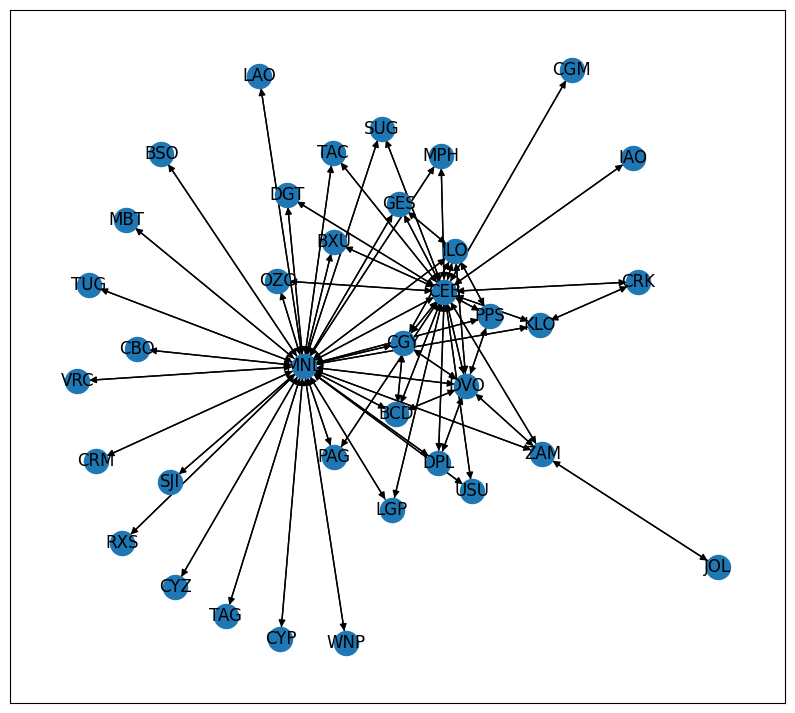

In [32]:
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)
plt.show()

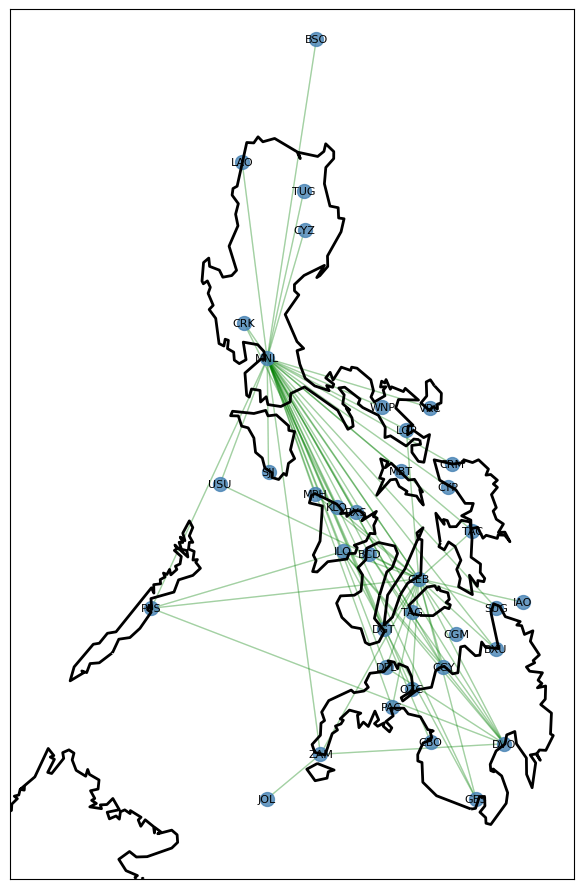

In [33]:
plt.figure(figsize = (10,9))
# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='l',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
     pos[elem] = (mx[count], my[count])

nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(), node_color='steelblue', alpha=0.8, node_size=100)
nx.draw_networkx_edges(G=graph, pos=pos, edge_color='g', alpha=0.2, arrows=False)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='black',
    font_weight='normal',
)

m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=2)
plt.tight_layout()
plt.show()

## Graph Analysis Summary

In [34]:
# Calculate the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(graph), key=len)
airport_largest_scc = graph.subgraph(largest_scc)

# Calculate the graph properties
N = airport_largest_scc.order()
L = airport_largest_scc.size()
degrees = [k for node, k in nx.degree(airport_largest_scc)]
avg_deg = float(L) * 2 / N
k_min = min(degrees)
k_max = max(degrees)
k_avg = sum(degrees) / N

# Calculate the average shortest path for the largest strongly connected component
avg_shortest_path = nx.average_shortest_path_length(airport_largest_scc)

# Create a DataFrame from the metrics
dict_airport = {
    'Nodes': N,
    'Edges': L,
    'Minimum degree': k_min,
    'Maximum degree': k_max,
    'Average degree': k_avg,
    'Average Shortest Path': avg_shortest_path
}

df = pd.DataFrame([dict_airport]).T.reset_index()
df.columns = ['Attribute', 'Value']
display(df)

Attribute       Value
0                  Nodes   37.000000
1                  Edges  130.000000
2         Minimum degree    2.000000
3         Maximum degree   64.000000
4         Average degree    7.027027
5  Average Shortest Path    2.009009

## Degree Distribution

In [39]:
# Calculate the in-degree centrality for each node
in_degree_centrality = nx.in_degree_centrality(graph)

# Calculate the out-degree centrality for each node
out_degree_centrality = nx.out_degree_centrality(graph)

# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(graph)

# Create a DataFrame with the number of nodes and their degrees
data = {
    'Airport Nodes': list(graph.nodes()),
    'Degree': [graph.degree(node) for node in graph.nodes()],
    'In-Degree': [graph.in_degree(node) for node in graph.nodes()],
    'Out-Degree': [graph.out_degree(node) for node in graph.nodes()],
    'Degree Centrality': [degree_centrality[node] for node in graph.nodes()],
    'In-Degree Centrality': [in_degree_centrality[node] for node in graph.nodes()],
    'Out-Degree Centrality': [out_degree_centrality[node] for node in graph.nodes()]
}
df_airport_degree = pd.DataFrame(data)
df_airport_degree = df_airport_degree.sort_values('In-Degree', ascending=False)

# Display the DataFrame with the degree, in-degree, out-degree, in-degree centrality, and out-degree centrality of each node in the Airport Network graph
display(df_airport_degree)

Airport Nodes  Degree  In-Degree  Out-Degree  Degree Centrality  \
4            MNL      64         32          32           1.777778   
1            CEB      44         22          22           1.222222   
3            DVO      16          8           8           0.444444   
14           ILO      12          6           6           0.333333   
2            CGY      10          5           5           0.277778   
0            BCD       8          4           4           0.222222   
24           ZAM       8          4           4           0.222222   
20           PPS       8          4           4           0.222222   
11           DPL       6          3           3           0.166667   
12           GES       6          3           3           0.166667   
15           KLO       6          3           3           0.166667   
17           MPH       4          2           2           0.111111   
23           USU       4          2           2           0.111111   
22           TAC       4          2           2           0.111111   
21           SUG       4          2           2           0.111111   
19           PAG       4          2           2           0.111111   
18           OZC       4          2           2           0.111111   
16           LGP       4          2           2           0.111111   
10           DGT       4          2           2           0.111111   
9            CRK       4          2           2           0.111111   
6            BXU       4          2           2           0.111111   
29           LAO       2          1           1           0.055556   
35           VRC       2          1           1           0.055556   
34           TUG       2          1           1           0.055556   
33           TAG       2          1           1           0.055556   
32           SJI       2          1           1           0.055556   
31           RXS       2          1           1           0.055556   
30           MBT       2          1           1           0.055556   
27           CYZ       2          1           1           0.055556   
28           JOL       2          1           1           0.055556   
13           IAO       2          1           1           0.055556   
26           CYP       2          1           1           0.055556   
25           CRM       2          1           1           0.055556   
5            BSO       2          1           1           0.055556   
7            CBO       2          1           1           0.055556   
8            CGM       2          1           1           0.055556   
36           WNP       2          1           1           0.055556   

    In-Degree Centrality  Out-Degree Centrality  
4               0.888889               0.888889  
1               0.611111               0.611111  
3               0.222222               0.222222  
14              0.166667               0.166667  
2               0.138889               0.138889  
0               0.111111               0.111111  
24              0.111111               0.111111  
20              0.111111               0.111111  
11              0.083333               0.083333  
12              0.083333               0.083333  
15              0.083333               0.083333  
17              0.055556               0.055556  
23              0.055556               0.055556  
22              0.055556               0.055556  
21              0.055556               0.055556  
19              0.055556               0.055556  
18              0.055556               0.055556  
16              0.055556               0.055556  
10              0.055556               0.055556  
9               0.055556               0.055556  
6               0.055556               0.055556  
29              0.027778               0.027778  
35              0.027778               0.027778  
34              0.027778               0.027778  
33              0.027778               0.027778  
32              0.027778               0.0

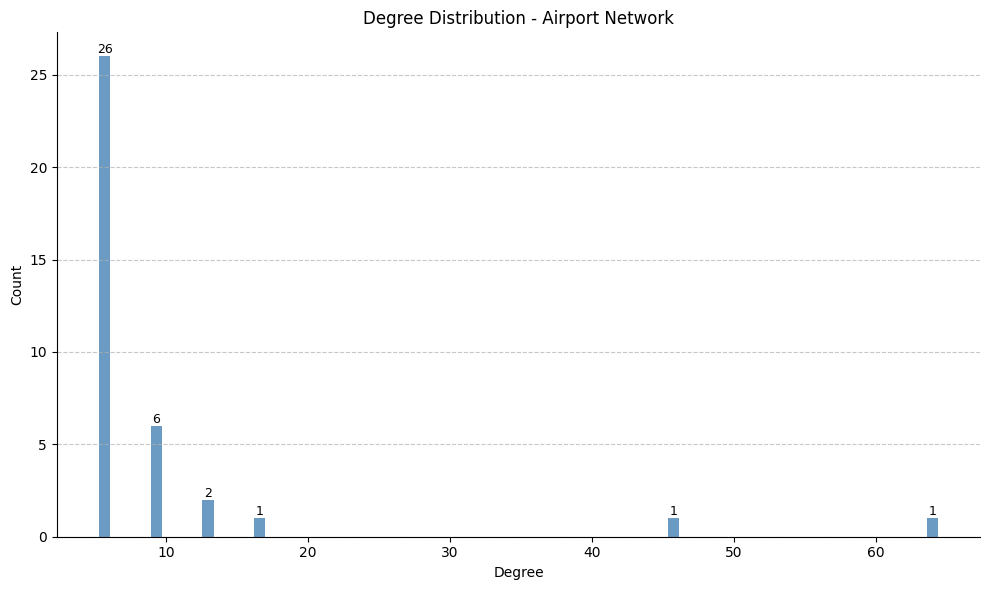

In [36]:
# Calculate the degree distribution
p, k = np.histogram([k for n, k in nx.degree(graph)], bins=17)

# Create a new figure and axes
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the degree distribution using a bar plot
plt.bar(k[1:], p, width=0.8, align='center', color='steelblue', alpha=0.8)

# Customize the plot
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution - Airport Network')

# Adding grid lines and removing right and top spines
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding annotations for bar heights
for i, height in enumerate(p):
    if height > 0:  # Check if the height is greater than zero before adding the annotation
        plt.text(k[i + 1], height, str(height), ha='center', va='bottom', fontsize=9, color='black')

# Show the plot
plt.tight_layout()
plt.show()

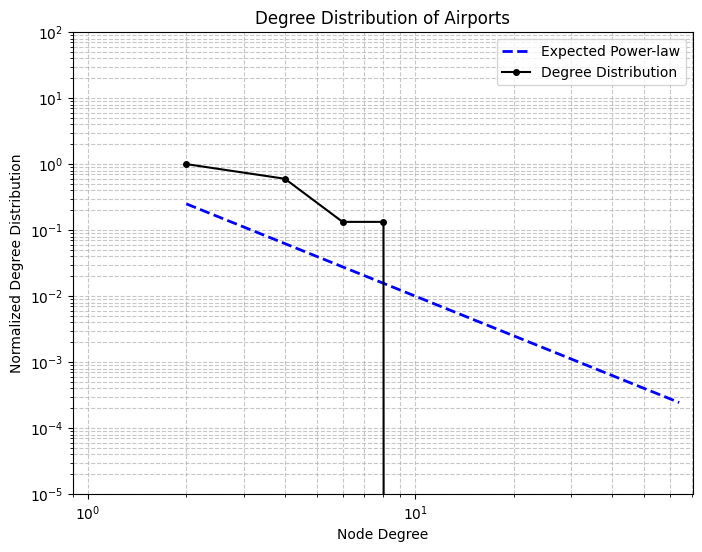

In [279]:
# Calculate the degree distribution
degree_distribution = df_airport_degree['Degree'].value_counts(normalize=True).sort_index()

# Normalize the degree distribution for visualization
normalized_degree_distribution = (degree_distribution - degree_distribution.min()) / (degree_distribution.max() - degree_distribution.min())

# Get the degree values and the normalized degree distribution values
degrees = degree_distribution.index
normalized_values = normalized_degree_distribution.values

plt.figure(figsize=(8, 6))  # Adjust the figure size for better visibility

# Plot the degree distribution and expected power-law
plt.plot(degrees, degrees**-2., "b--", label="Expected Power-law", linewidth=2)
plt.plot(degrees, normalized_values, 'k.-', label="Degree Distribution", markersize=8)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Degree Distribution')
plt.title('Degree Distribution of Airports')
plt.legend()

# Adjust axis limits for better visibility
plt.xlim(0.9, degrees.max() * 1.1)
plt.ylim(10**(-5), 100)

plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()

## Shortest Path

In [68]:
# Calculate all-pairs shortest path lengths
data_shortest_path = list(nx.all_pairs_shortest_path_length(graph))

# Create a DataFrame from the data
df_shortest_path = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in data_shortest_path}, orient='index')
df_shortest_path = df_shortest_path.sort_index(axis=1)

# Display the DataFrame
pd.set_option('display.max_columns', None)
display(df_shortest_path)

BCD  BSO  BXU  CBO  CEB  CGM  CGY  CRK  CRM  CYP  CYZ  DGT  DPL  DVO  \
BCD    0    2    2    2    1    2    1    2    2    2    2    2    2    1   
CEB    1    2    1    2    0    1    1    1    2    2    2    1    1    1   
CGY    1    2    2    2    1    2    0    2    2    2    2    2    2    1   
DVO    1    2    2    2    1    2    1    2    2    2    2    2    1    0   
MNL    1    1    1    1    1    2    1    2    1    1    1    1    1    1   
BSO    2    0    2    2    2    3    2    3    2    2    2    2    2    2   
BXU    2    2    0    2    1    2    2    2    2    2    2    2    2    2   
CBO    2    2    2    0    2    3    2    3    2    2    2    2    2    2   
CGM    2    3    2    3    1    0    2    2    3    3    3    2    2    2   
CRK    2    3    2    3    1    2    2    0    3    3    3    2    2    2   
DGT    2    2    2    2    1    2    2    2    2    2    2    0    2    2   
DPL    2    2    2    2    1    2    2    2    2    2    2    2    0    1   
GES    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
IAO    2    3    2    3    1    2    2    2    3    3    3    2    2    2   
ILO    2    2    2    2    1    2    1    2    2    2    2    2    2    1   
KLO    2    2    2    2    1    2    2    1    2    2    2    2    2    2   
LGP    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
MPH    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
OZC    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
PAG    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
PPS    2    2    2    2    1    2    2    2    2    2    2    2    2    1   
SUG    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
TAC    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
USU    2    2    2    2    1    2    2    2    2    2    2    2    2    2   
ZAM    2    2    2    2    1    2    2    2    2    2    2    2    2    1   
CRM    2    2    2    2    2    3    2    3    0    2    2    2    2    2   
CYP    2    2    2    2    2    3    2    3    2    0    2    2    2    2   
CYZ    2    2    2    2    2    3    2    3    2    2    0    2    2    2   
JOL    3    3    3    3    2    3    3    3    3    3    3    3    3    2   
LAO    2    2    2    2    2    3    2    3    2    2    2    2    2    2   
MBT    2    2    2    2    2    3    2    3    2    2    2    2    2    2   
RXS    2    2    2    2    2    3    2    3    2    2    2    2    2    2   
SJI    2    2    2    2    2    3    2    3    2    2    2    2    2    2   
TAG    2    2    2    2    2    3    2    3    2    2    2    2    2    2   
TUG    2    2    2    2    2    3    2    3    2    2    2    2    2    2   
VRC    2    2    2    2    2    3    2    3    2    2    2    2    2    2   
WNP    2    2    2    2    2    3    2    3    2    2    2    2    2    2   

     GES  IAO  ILO  JOL  KLO  LAO  LGP  MBT  MNL  MPH  OZC  PAG  PPS  RXS  \
BCD    2    2    2    3    2    2    2    2    1    2    2    2    2    2   
CEB    1    1    1    2    1    2    1    2    1    1    1    1    1    2   
CGY    2    2    1    3    2    2    2    2    1    2    2    2    2    2   
DVO    2    2    1    2    2    2    2    2    1    2    2    2    1    2   
MNL    1    2    1    2    1    1    1    1    0    1    1    1    1    1   
BSO    2    3    2    3    2    2    2    2    1    2    2    2    2    2   
BXU    2    2    2    3    2    2    2    2    1    2    2    2    2    2   
CBO    2    3    2    3    2    2    2    2    1    2    2    2    2    2   
CGM    2    2    2    3    2    3    2    3    2    2    2    2    2    3   
CRK    2    2    2    3    1    3    2    3    2    2    2    2    2    3   
DGT    2    2    2    3    2    2    2    2    1    2    2    2    2    2   
DPL    2    2    2    3    2    2    2    2    1    2    2    2    2    2   
GES    0    2    1    3    2    2    2    2    1    2    2    2    2    2   


In [69]:
# Calculate mean shortest path values
mean_values = df_shortest_path.mean(axis=1)

# Calculate the average shortest path in the entire graph
average_shortest_path = nx.average_shortest_path_length(graph)

# Create a DataFrame to store the results
result_df = pd.DataFrame({
    'Node': mean_values.index,
    'Mean Path': mean_values.values
})

# Sort the DataFrame by the mean path values
result_df = result_df.sort_values(by='Mean Path')

# Display the DataFrame
display(result_df)

# Print the average shortest path
print(f'Average shortest path: {average_shortest_path}')

Node  Mean Path
4   MNL   1.081081
1   CEB   1.351351
3   DVO   1.729730
14  ILO   1.810811
2   CGY   1.837838
24  ZAM   1.837838
0   BCD   1.864865
20  PPS   1.864865
11  DPL   1.891892
12  GES   1.891892
15  KLO   1.891892
23  USU   1.918919
22  TAC   1.918919
21  SUG   1.918919
19  PAG   1.918919
17  MPH   1.918919
18  OZC   1.918919
10  DGT   1.918919
6   BXU   1.918919
16  LGP   1.918919
26  CYP   2.027027
34  TUG   2.027027
33  TAG   2.027027
32  SJI   2.027027
31  RXS   2.027027
30  MBT   2.027027
29  LAO   2.027027
36  WNP   2.027027
25  CRM   2.027027
5   BSO   2.027027
7   CBO   2.027027
35  VRC   2.027027
27  CYZ   2.027027
9   CRK   2.270270
8   CGM   2.297297
13  IAO   2.297297
28  JOL   2.783784

Average shortest path: 2.009009009009009


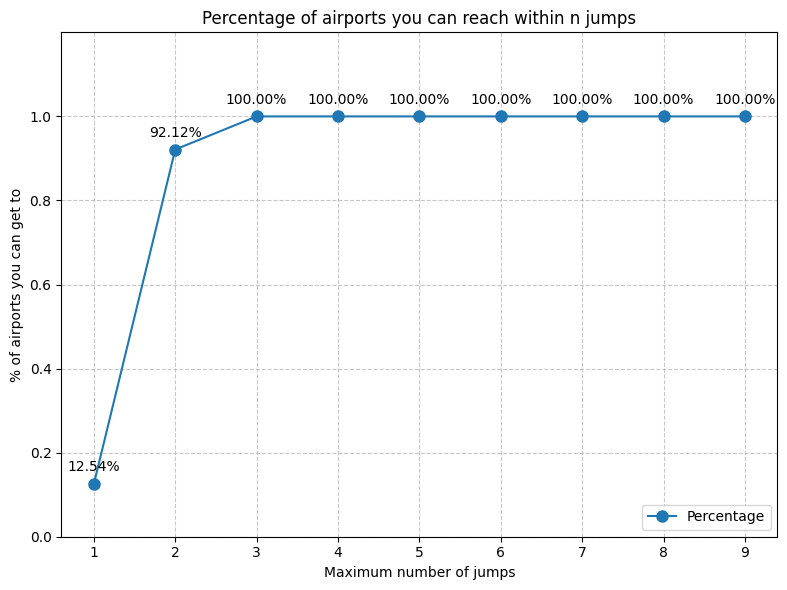

In [251]:
def separation_degrees(shortest_paths, with_n_jumps):
    n = len(shortest_paths)
    coef = []
    for node in shortest_paths:
        shortest_path = shortest_paths[node]
        jumps = np.array(list(shortest_path.values()))
        # Ratio of airports that are reachable with n jumps
        coef.append(np.float(len(jumps[jumps <= with_n_jumps])) / np.float(n - 1))
    return np.mean(coef)

# Assuming you have 'graph' defined here
shortest_paths = dict(nx.shortest_path_length(graph))

sample = []
for i in np.arange(1, 10):
    perc = separation_degrees(shortest_paths, i)
    sample.append(perc)

# Clip the values to ensure they are between 0 and 1
sample = np.clip(sample, 0, 1)

plt.figure(figsize=(8, 6))  # Adjust the figure size for better visibility

# Plot the data points and line
plt.plot(np.arange(1, 10), sample, 'o-', markersize=8, label='Percentage')
plt.xlabel('Maximum number of jumps')
plt.ylabel('% of airports you can get to')
plt.ylim(0, 1.2)  # Set the y-axis limit to 1.0
plt.xticks(np.arange(1, 10))  # Set the x-axis ticks to match the data points
plt.yticks(np.arange(0, 1.2, 0.2))  # Improve y-axis ticks to show percentage values

# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a title and legend
plt.title('Percentage of airports you can reach within n jumps')
plt.legend(loc='lower right')

# Adding data labels
for a, b in zip(np.arange(1, 10), sample):
    plt.text(a, b + 0.03, f'{b:.2%}', ha='center')

plt.tight_layout()
plt.show()

In [103]:
def jumps_to_reach_any_airport(shortest_paths,city):
    max_jump = [{i: max(shortest_paths[i].values())} for i in shortest_paths]
    finalMap = {}
    for max_jump_per_cities in max_jump:
        finalMap.update(max_jump_per_cities)
    return finalMap[city]

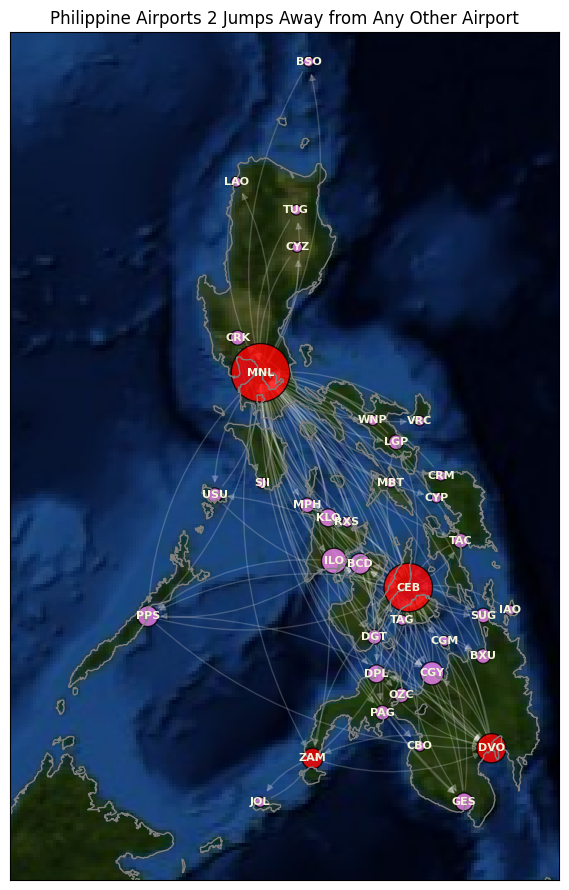

In [144]:
newL = [{i: max(shortest_paths[i].values())} for i in shortest_paths]
finalMap = {}
for d in newL:
    finalMap.update(d)

ph_hubs = [{i:j} for i,j in zip(finalMap,finalMap.values()) if j==min(finalMap.values())]
ph_hubs = [list(d.keys())[0] for d in ph_hubs]

plt.figure(figsize = (10,9))
# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
     pos[elem] = (mx[count], my[count])

# Calculate the degree centrality of nodes
degree_centrality = nx.degree_centrality(graph)

# Set node sizes based on degree centrality
node_sizes = [degree_centrality[node] * 1000 for node in graph.nodes()]

# Determine the min jump value as the cutoff for ph hubs
cutoff = 2

pos_data['Jumps'] = [jumps_to_reach_any_airport(shortest_paths,i) for i in pos_data['IATA']]

# Assign colors based on the jump value
node_colors = ['red' if jumps <= cutoff else 'violet' for jumps in pos_data.set_index('IATA').reindex(graph.nodes()).reset_index()['Jumps']]

nx.draw_networkx_nodes(
    G=graph,
    pos=pos,
    nodelist=graph.nodes(),
    node_color=node_colors,
    edgecolors='black',  # White node borders
    alpha=0.8,
    node_size=node_sizes
)

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# # Set the z-order to bring edges behind nodes and labels
# edges.set_zorder(0)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

# Customize the map colors
m.bluemarble()
# m.drawmapboundary(fill_color='lightgray')  # Light gray map background
# m.fillcontinents(color='coral',lake_color='aqua')  # White land and light gray lakes

m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

plt.title('Philippine Airports 2 Jumps Away from Any Other Airport')
plt.tight_layout()
plt.show()

## Clustering Coefficient

In [73]:
# Calculate the clustering coefficient for each node
clustering_coefficients = {i: nx.clustering(graph, i) for i in graph.nodes()}

# Create a DataFrame to store the clustering coefficient for each node
df_clustering = pd.DataFrame(clustering_coefficients.items(), columns=['Node', 'Clustering Coefficient'])

# Calculate the degree for each node in the graph
degrees = graph.degree()

# Convert the dictionary of degrees to a DataFrame
df_degrees = pd.DataFrame(degrees, columns=['Node', 'Degree'])

# Merge the degree information into the existing DataFrame using the 'Node' column as the key
df_clustering = df_clustering.merge(df_degrees, on='Node')

# Print the DataFrame with clustering coefficients and degrees for each node
display(df_clustering)

# Calculate and print the average clustering coefficient
average_clustering_coefficient = df_clustering['Clustering Coefficient'].mean()
print(f"\nAverage Clustering Coefficient: {average_clustering_coefficient}")

Node  Clustering Coefficient  Degree
0   BCD                1.000000       8
1   CEB                0.125541      44
2   CGY                0.900000      10
3   DVO                0.571429      16
4   MNL                0.056452      64
5   BSO                0.000000       2
6   BXU                1.000000       4
7   CBO                0.000000       2
8   CGM                0.000000       2
9   CRK                1.000000       4
10  DGT                1.000000       4
11  DPL                1.000000       6
12  GES                1.000000       6
13  IAO                0.000000       2
14  ILO                0.733333      12
15  KLO                0.666667       6
16  LGP                1.000000       4
17  MPH                1.000000       4
18  OZC                1.000000       4
19  PAG                1.000000       4
20  PPS                1.000000       8
21  SUG                1.000000       4
22  TAC                1.000000       4
23  USU                1.000000       4
24  ZAM                0.500000       8
25  CRM                0.000000       2
26  CYP                0.000000       2
27  CYZ                0.000000       2
28  JOL                0.000000       2
29  LAO                0.000000       2
30  MBT                0.000000       2
31  RXS                0.000000       2
32  SJI                0.000000       2
33  TAG                0.000000       2
34  TUG                0.000000       2
35  VRC                0.000000       2
36  WNP                0.000000       2


Average Clustering Coefficient: 0.4744167921587277


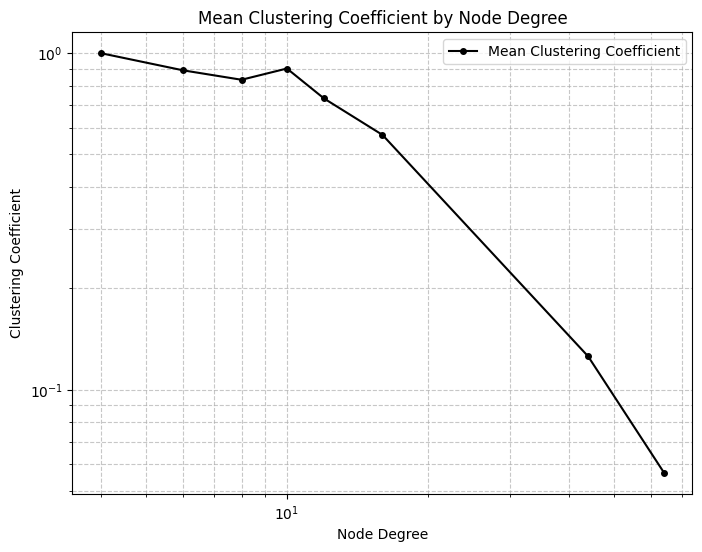

In [254]:
# Group by degree and calculate the mean clustering coefficient
cluster_gr = df_clustering.groupby('Degree')['Clustering Coefficient'].mean()

plt.figure(figsize=(8, 6))  # Adjust the figure size for better visibility

# Plot the data points with markers
plt.plot(cluster_gr.index[1:], cluster_gr.values[1:], 'k.-', markersize=8, label='Mean Clustering Coefficient')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Node Degree')
plt.ylabel('Clustering Coefficient')
plt.title('Mean Clustering Coefficient by Node Degree')
plt.legend()

plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.show()

## Neighbors

In [71]:
# Print neighbors for all nodes in the graph
for node in graph.nodes():
    neighbors = list(graph.neighbors(node))
    print(f'Neighbors of {node}: {neighbors}')

Neighbors of BCD: ['CEB', 'CGY', 'DVO', 'MNL']
Neighbors of CEB: ['BCD', 'BXU', 'CGM', 'CGY', 'CRK', 'DGT', 'DPL', 'DVO', 'GES', 'IAO', 'ILO', 'KLO', 'LGP', 'MNL', 'MPH', 'OZC', 'PAG', 'PPS', 'SUG', 'TAC', 'USU', 'ZAM']
Neighbors of CGY: ['BCD', 'CEB', 'DVO', 'ILO', 'MNL']
Neighbors of DVO: ['BCD', 'CEB', 'CGY', 'DPL', 'ILO', 'MNL', 'PPS', 'ZAM']
Neighbors of MNL: ['BCD', 'BSO', 'BXU', 'CBO', 'CEB', 'CGY', 'CRM', 'CYP', 'CYZ', 'DGT', 'DPL', 'DVO', 'GES', 'ILO', 'KLO', 'LAO', 'LGP', 'MBT', 'MPH', 'OZC', 'PAG', 'PPS', 'RXS', 'SJI', 'SUG', 'TAC', 'TAG', 'TUG', 'USU', 'VRC', 'WNP', 'ZAM']
Neighbors of BSO: ['MNL']
Neighbors of BXU: ['CEB', 'MNL']
Neighbors of CBO: ['MNL']
Neighbors of CGM: ['CEB']
Neighbors of CRK: ['CEB', 'KLO']
Neighbors of DGT: ['CEB', 'MNL']
Neighbors of DPL: ['CEB', 'DVO', 'MNL']
Neighbors of GES: ['CEB', 'ILO', 'MNL']
Neighbors of IAO: ['CEB']
Neighbors of ILO: ['CEB', 'CGY', 'DVO', 'GES', 'MNL', 'PPS']
Neighbors of KLO: ['CEB', 'CRK', 'MNL']
Neighbors of LGP: ['CEB'

## Centrality Analysis

### Degree Centrality

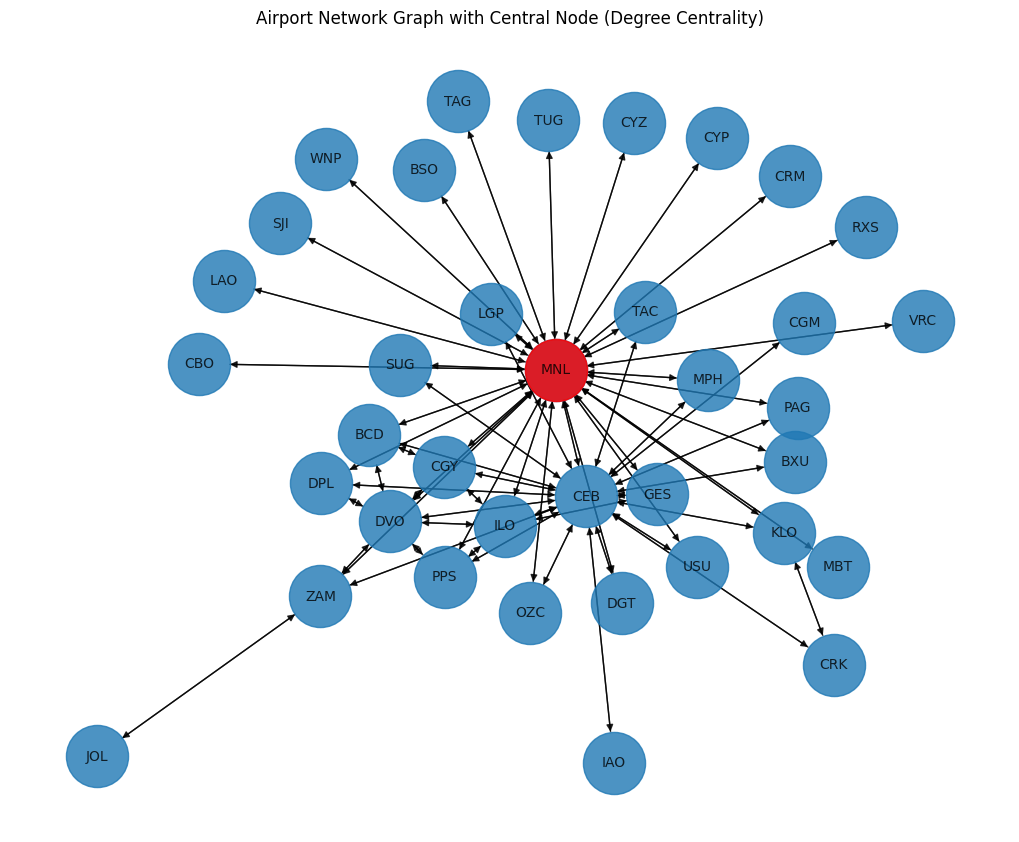

The central node is: MNL


In [145]:
# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(graph)

# Find the node with the highest degree centrality (most central node)
central_node = max(degree_centrality, key=degree_centrality.get)

# Visualize the graph with the central node highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph, seed=42)

# Draw the graph
nx.draw(graph, pos, with_labels=True, node_size=2000, font_size=10, alpha=0.8)

# Highlight the central node
nx.draw_networkx_nodes(graph, pos, nodelist=[central_node], node_color='red', node_size=2000, alpha=0.8)

# Set plot title
plt.title("Airport Network Graph with Central Node (Degree Centrality)")

# Show the plot
plt.show()

# Print the name of the central node
print(f"The central node is: {central_node}")

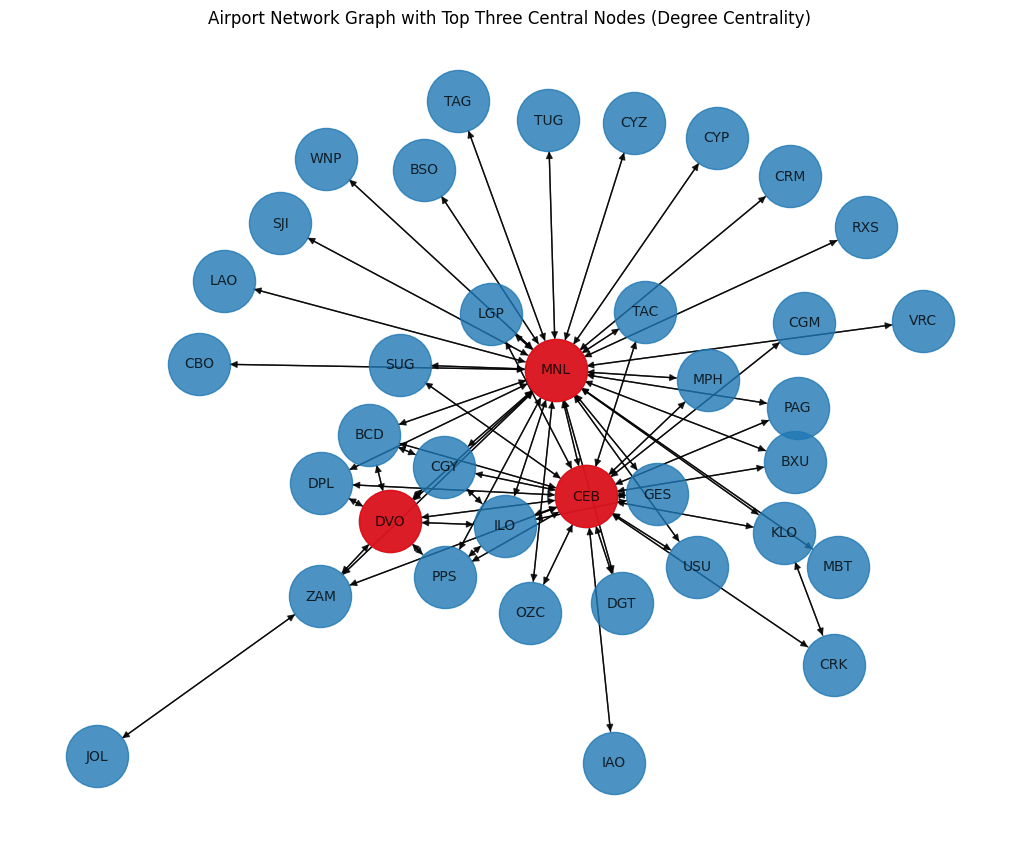

The top 3 central nodes are: MNL, CEB, DVO


In [146]:
# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(graph)

# Set the centrality threshold for central nodes (0.25 in this example)
centrality_threshold = 0.4

# Filter the nodes based on the centrality threshold
central_nodes = [node for node, centrality in degree_centrality.items() if centrality > centrality_threshold]

# Sort the central nodes by degree centrality in descending order
central_nodes_sorted = sorted(central_nodes, key=lambda node: degree_centrality[node], reverse=True)

# Select the top n central nodes to visualize (e.g., n = 3)
n = 3
top_n_central_nodes = central_nodes_sorted[:n]

# Visualize the graph with the top n central nodes highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph, seed=42)

# Draw the graph
nx.draw(graph, pos, with_labels=True, node_size=2000, font_size=10, alpha=0.8)

# Highlight the top n central nodes in red
nx.draw_networkx_nodes(graph, pos, nodelist=top_n_central_nodes, node_color='red', node_size=2000, alpha=0.8)

# Set plot title
plt.title("Airport Network Graph with Top Three Central Nodes (Degree Centrality)")

# Show the plot
plt.show()

# Print the names of the top n central nodes
print(f"The top {n} central nodes are: {', '.join(top_n_central_nodes)}")

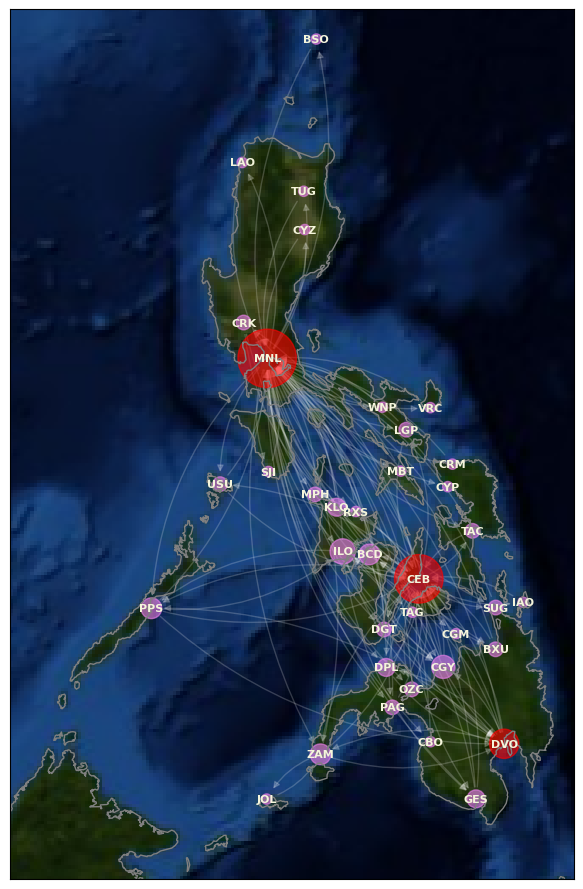

In [158]:
plt.figure(figsize = (10,9))
# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
     pos[elem] = (mx[count], my[count])

# Calculate the degree centrality of nodes
degree_centrality = nx.degree_centrality(graph)

# Set node sizes based on degree centrality
node_sizes = [degree_centrality[node] * 1000 for node in graph.nodes()]

# Determine the median total_flight value as the cutoff for large and small airports
cutoff = 15

# Assign colors based on the total_flight value
node_colors = ['red' if total_flight >= cutoff else 'violet' for total_flight in pos_data.set_index('IATA').reindex(graph.nodes()).reset_index()['total_flight']]

nx.draw_networkx_nodes(
    G=graph,
    pos=pos,
    nodelist=graph.nodes(),
    node_color=node_colors,
    edgecolors=None,  # White node borders
    alpha=0.6,
    node_size=node_sizes
)

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# # Set the z-order to bring edges behind nodes and labels
# edges.set_zorder(0)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

# Customize the map colors
m.bluemarble()
# m.drawmapboundary(fill_color='lightgray')  # Light gray map background
# m.fillcontinents(color='coral',lake_color='aqua')  # White land and light gray lakes

m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines


plt.tight_layout()
plt.show()

### Betweenness Centrality

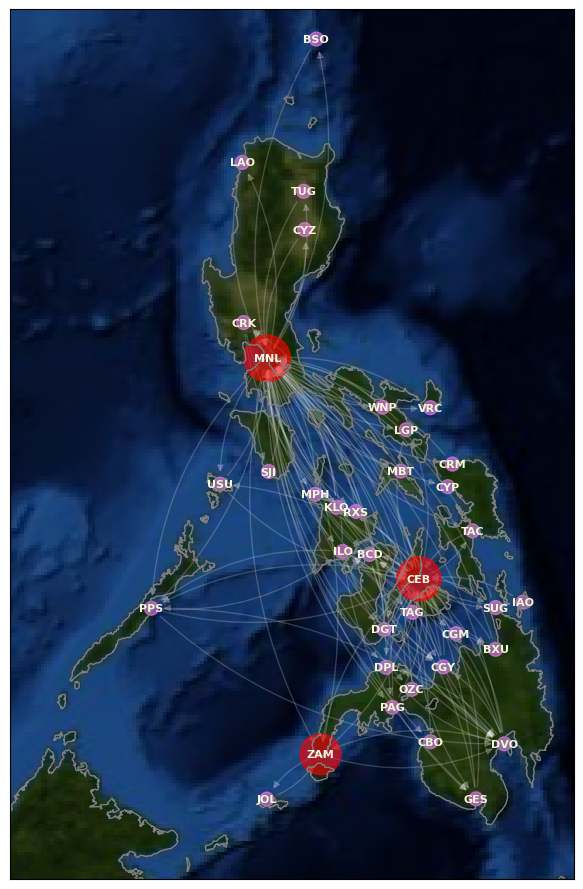

In [200]:
plt.figure(figsize=(10, 9))

# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate(pos_data['IATA']):
     pos[elem] = (mx[count], my[count])

# Calculate the betweenness centrality of nodes
betweenness_centrality = nx.betweenness_centrality(graph)

# Set node sizes based on betweenness centrality
node_sizes = [np.log(betweenness_centrality[node] * 100000) * 100 if betweenness_centrality[node] >= 0.05 else 100  for node in graph.nodes()]

# Determine the median total_flight value as the cutoff for large and small airports
cutoff = 15

# Assign colors based on the total_flight value
node_colors = ['red' if betweenness_centrality[node] >= 0.05 else 'violet' for node in graph.nodes()]

nx.draw_networkx_nodes(
    G=graph,
    pos=pos,
    nodelist=graph.nodes(),
    node_color=node_colors,
    edgecolors=None,  # Remove node borders
    alpha=0.6,
    node_size=node_sizes
)

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

# Customize the map colors
m.bluemarble()

m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

plt.tight_layout()
plt.show()

### Closeness Centrality

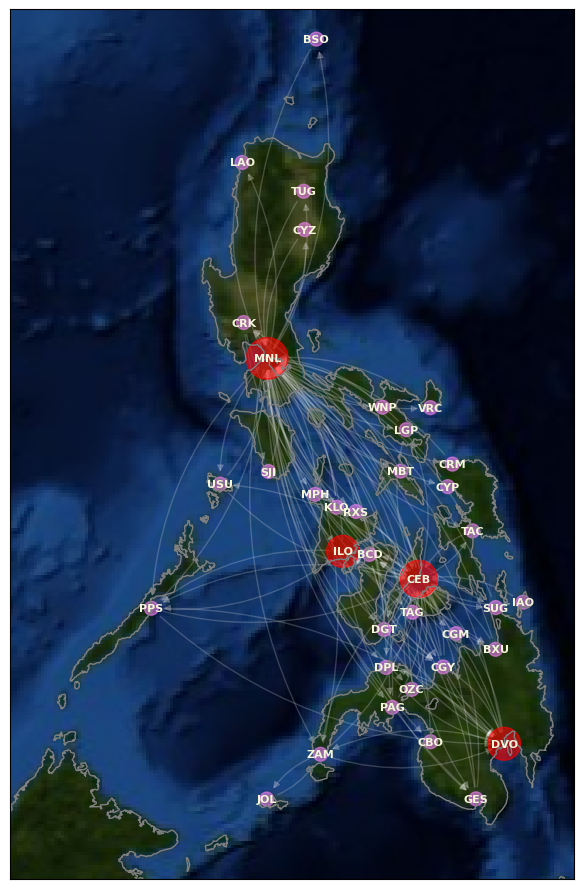

In [195]:
plt.figure(figsize=(10, 9))

# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate(pos_data['IATA']):
     pos[elem] = (mx[count], my[count])

# Calculate the betweenness centrality of nodes
closeness_centrality = nx.closeness_centrality(graph)

# Set node sizes based on betweenness centrality
node_sizes = [closeness_centrality[node] * 1000 if closeness_centrality[node] >= 0.53 else 100 for node in graph.nodes()]

# Determine the median total_flight value as the cutoff for large and small airports
cutoff = 15

# Assign colors based on the total_flight value
node_colors = ['red' if closeness_centrality[node] >= 0.53 else 'violet' for node in graph.nodes()]

nx.draw_networkx_nodes(
    G=graph,
    pos=pos,
    nodelist=graph.nodes(),
    node_color=node_colors,
    edgecolors=None,  # Remove node borders
    alpha=0.6,
    node_size=node_sizes
)

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

# Customize the map colors
m.bluemarble()

m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

plt.tight_layout()
plt.show()

### Pagerank Centrality

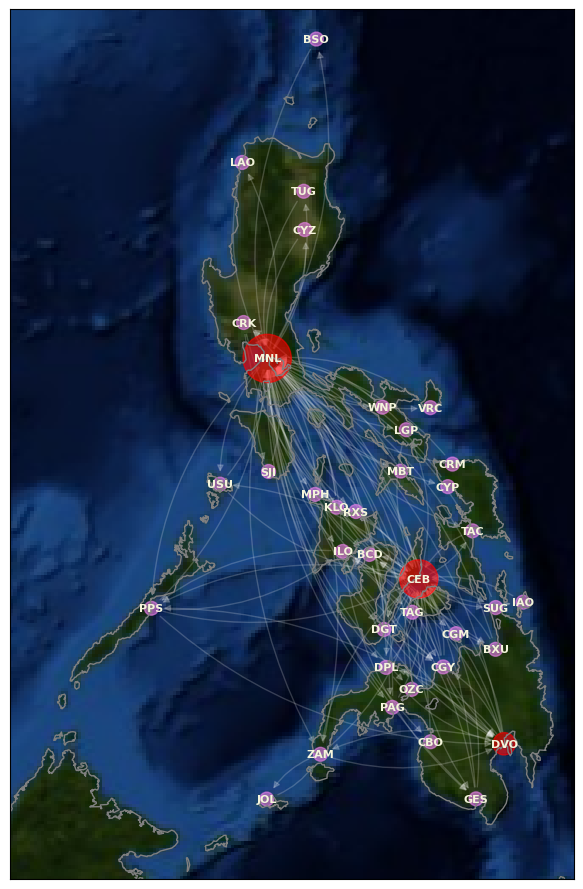

In [204]:
plt.figure(figsize=(10, 9))

# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate(pos_data['IATA']):
     pos[elem] = (mx[count], my[count])

# Calculate the betweenness centrality of nodes
pagerank_centrality = nx.pagerank(graph)

# Set node sizes based on betweenness centrality
node_sizes = [pagerank_centrality[node] * 5000 if pagerank_centrality[node] >= 0.05 else 100 for node in graph.nodes()]

# Determine the median total_flight value as the cutoff for large and small airports
cutoff = 15

# Assign colors based on the total_flight value
node_colors = ['red' if pagerank_centrality[node] >= 0.05 else 'violet' for node in graph.nodes()]

nx.draw_networkx_nodes(
    G=graph,
    pos=pos,
    nodelist=graph.nodes(),
    node_color=node_colors,
    edgecolors=None,  # Remove node borders
    alpha=0.6,
    node_size=node_sizes
)

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

# Customize the map colors
m.bluemarble()

m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

plt.tight_layout()
plt.show()

## Communities

### Girvan-Newman Algorithm

In [211]:
# Detect the communities in the graph using the Girvan-Newman algorithm
communities_generator = nx.algorithms.community.girvan_newman(graph)
communities = list(communities_generator)

# Get the number of communities
num_communities = len(communities)

# Print the number of communities
print(f"Number of communities in the Airport Network: {num_communities}")

Number of communities in the Airport Network: 36


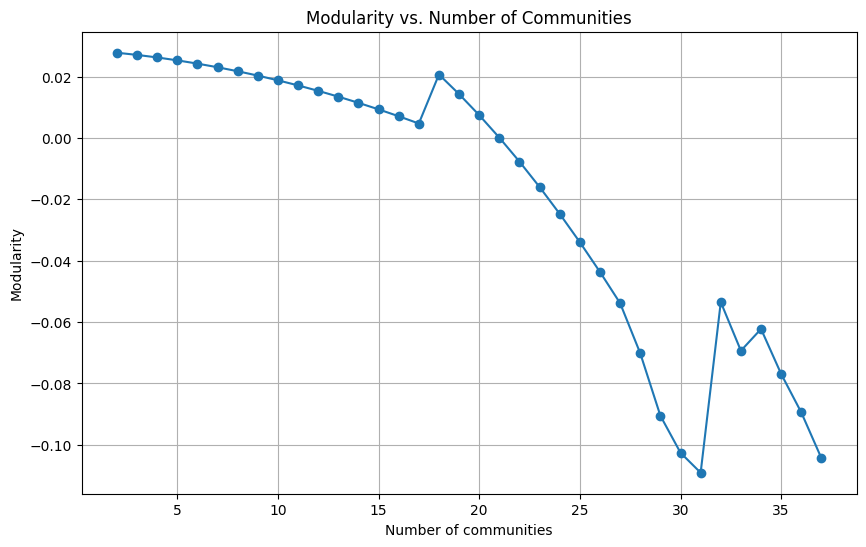

Ideal number of next-level communities: 2


In [213]:
# Detect the communities in the graph using the Girvan-Newman algorithm
communities_generator = girvan_newman(graph)

# Calculate the modularity for each partition at each level
modularity_values = []
for communities in communities_generator:
    modularity_value = modularity(graph, communities)
    modularity_values.append((len(communities), modularity_value))

# Extract the number of communities and modularity values
num_communities, modularity_scores = zip(*modularity_values)

# Plot the modularity values
plt.figure(figsize=(10, 6))
plt.plot(num_communities, modularity_scores, marker='o')
plt.xlabel('Number of communities')
plt.ylabel('Modularity')
plt.title('Modularity vs. Number of Communities')
plt.grid(True)
plt.show()

# Find the ideal number of next-level communities based on modularity
ideal_num_communities = num_communities[modularity_scores.index(max(modularity_scores))]
print(f"Ideal number of next-level communities: {ideal_num_communities}")

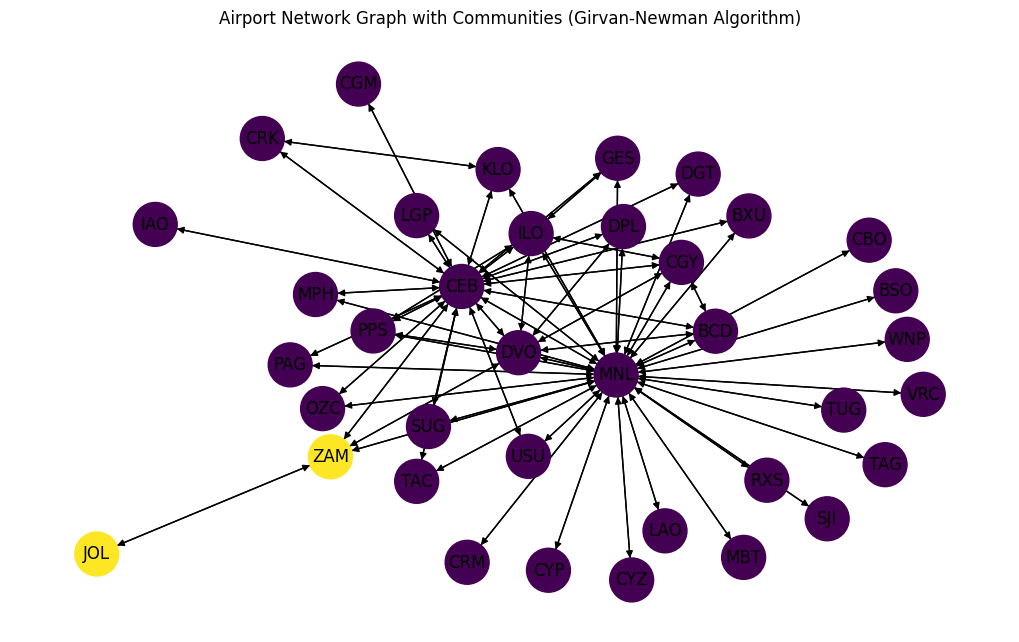

In [214]:
# Detect the communities in the graph using the Girvan-Newman algorithm
communities_generator = girvan_newman(graph)
best_modularity = -1
best_communities = None

for communities in communities_generator:
    # Calculate the modularity for the current community structure
    curr_modularity = modularity(graph, communities)

    # Check if the current modularity is better than the best one so far
    if curr_modularity > best_modularity:
        best_modularity = curr_modularity
        best_communities = communities

# Create a mapping of nodes to their respective community (as integers)
community_mapping = {}
for i, community in enumerate(best_communities):
    for node in community:
        community_mapping[node] = i

# Create a list of colors for each node based on its community
node_colors = [community_mapping[node] for node in graph.nodes()]

# Draw the graph with nodes colored by community using a spring layout
plt.figure(figsize=(10, 6))
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', len(best_communities)), with_labels=True, node_size=1000)
plt.title("Airport Network Graph with Communities (Girvan-Newman Algorithm)")
plt.show()

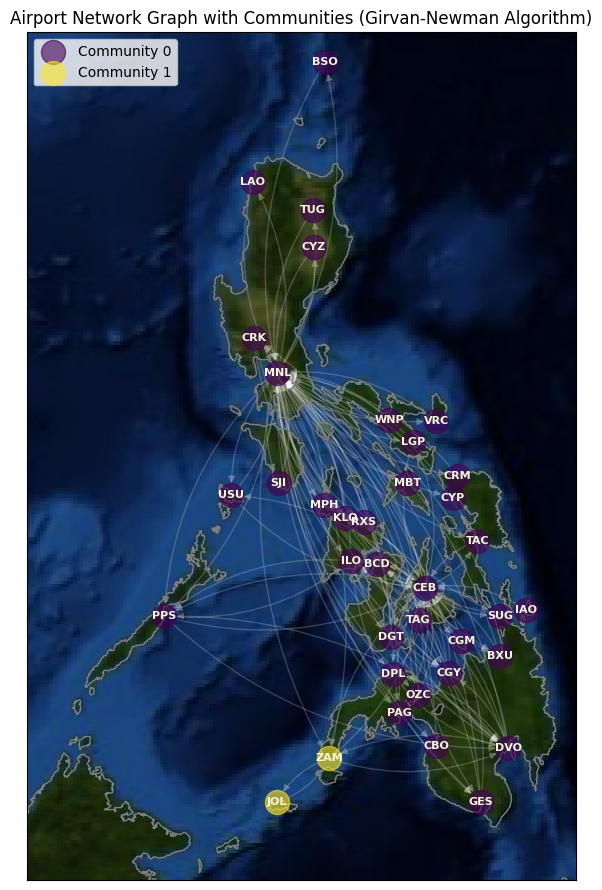

In [222]:
# Detect the communities in the graph using the Girvan-Newman algorithm
communities_generator = girvan_newman(graph)
communities = next(communities_generator)

# Create a mapping of nodes to their respective community (as integers)
community_mapping = {}
for i, community in enumerate(communities):
    for node in community:
        community_mapping[node] = i

# Define a colormap for the communities
num_communities = len(set(community_mapping.values()))
colormap = plt.cm.get_cmap('viridis', num_communities)

plt.figure(figsize=(10, 9))

# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate(pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

# Draw the map with the airports colored by community
m.bluemarble()
m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

# Draw the nodes with colors based on the communities
for community_id in set(community_mapping.values()):
    nodes_in_community = [node for node in graph.nodes() if community_mapping[node] == community_id]
    nx.draw_networkx_nodes(
        G=graph,
        pos=pos,
        nodelist=nodes_in_community,
        node_color=colormap(community_id),
        node_size=300,
        alpha=0.6,
        label=f'Community {community_id}'
    )

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

plt.legend(loc='upper left')
plt.title("Airport Network Graph with Communities (Girvan-Newman Algorithm)")
plt.tight_layout()
plt.show()

### Louvain Algorithm

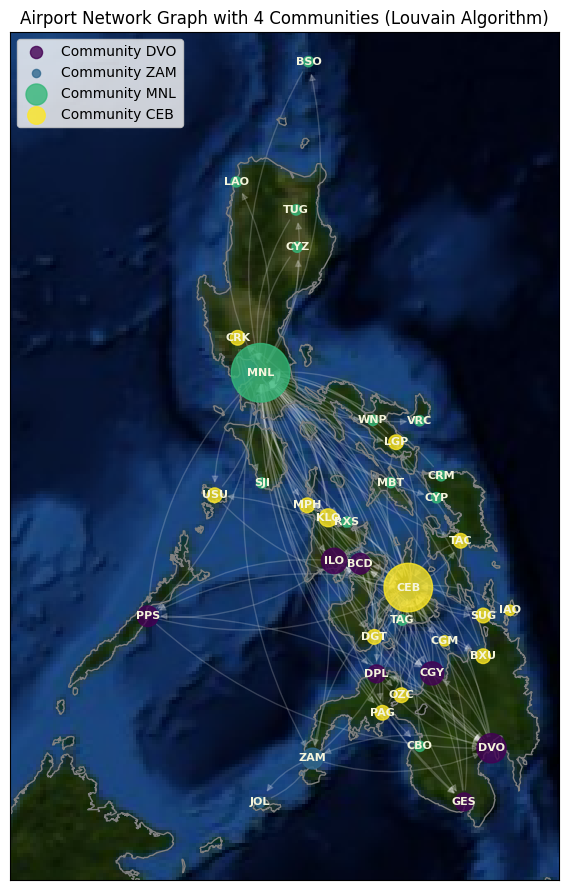

In [250]:
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from mpl_toolkits.basemap import Basemap

# Your code to create the 'graph' goes here

# Convert the graph to a non-directed graph
ungraph = graph.to_undirected()

# Detect the communities in the graph using the Louvain algorithm
partition = community_louvain.best_partition(ungraph)

# Get the number of communities
num_communities = max(partition.values()) + 1

# Create a mapping of nodes to their respective community (as integers)
community_mapping = {}
for node, community_id in partition.items():
    community_mapping[node] = community_id

# Calculate the degree centrality of nodes
degree_centrality = nx.degree_centrality(graph)

# Define a colormap for the communities
colormap = plt.cm.get_cmap('viridis', num_communities)

plt.figure(figsize=(10, 9))

# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate(pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

# Draw the map with the airports colored by community
m.bluemarble()
m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

# Create a custom legend for the communities
community_labels = {
    0: 'Community DVO',
    1: 'Community ZAM',
    2: 'Community MNL',
    3: 'Community CEB',
    # Add more communities here if needed
}

# Draw the nodes with colors and sizes based on the communities and degree centrality
for community_id in set(community_mapping.values()):
    nodes_in_community = [node for node in ungraph.nodes() if community_mapping[node] == community_id]
    node_sizes = [degree_centrality[node] * 1000 for node in nodes_in_community]
    nx.draw_networkx_nodes(
        G=ungraph,
        pos=pos,
        nodelist=nodes_in_community,
        node_color=colormap(community_id),
        node_size=node_sizes,
        alpha=0.8,
        label=community_labels.get(community_id, f'Community {community_id}')
    )

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# Add labels to the nodes
labels = {elem: elem for elem in ungraph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=ungraph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

plt.legend(loc='upper left', markerscale=0.5)
plt.title(f"Airport Network Graph with {num_communities} Communities (Louvain Algorithm)")
plt.tight_layout()
plt.show()


# Scenario Analysis

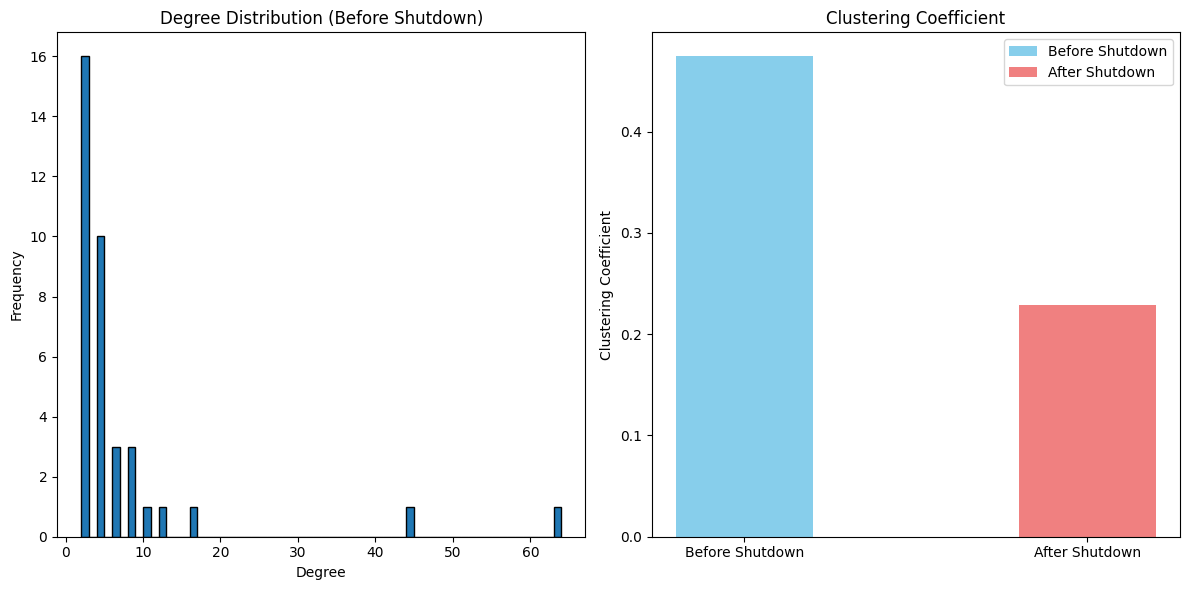

In [281]:
# Calculate initial network properties (before shutdown)
initial_average_degree = np.mean([degree for node, degree in graph.degree()])
initial_clustering_coefficient = nx.average_clustering(graph)

# Identify the central node to shut down (for this example, let's use the node with the highest degree)
central_node_to_shutdown = max(graph.degree(), key=lambda x: x[1])[0]

# Simulate the shutdown
graph_after_shutdown = graph.copy()
graph_after_shutdown.remove_node(central_node_to_shutdown)

# Calculate network properties after shutdown
after_shutdown_average_degree = np.mean([degree for node, degree in graph_after_shutdown.degree()])
after_shutdown_clustering_coefficient = nx.average_clustering(graph_after_shutdown)

# Visualization
plt.figure(figsize=(12, 6))

# Plot degree distribution before shutdown
plt.subplot(1, 2, 1)
degrees_before_shutdown = [degree for node, degree in graph.degree()]
plt.hist(degrees_before_shutdown, bins=np.arange(min(degrees_before_shutdown), max(degrees_before_shutdown)+1), edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Before Shutdown)')

# Plot clustering coefficient before and after shutdown
plt.subplot(1, 2, 2)
clustering_coefficients = [nx.clustering(graph, node) for node in graph.nodes()]
plt.bar(0, initial_clustering_coefficient, color='skyblue', label='Before Shutdown', width=0.4)
plt.bar(1, after_shutdown_clustering_coefficient, color='lightcoral', label='After Shutdown', width=0.4)
plt.xticks([0, 1], ['Before Shutdown', 'After Shutdown'])
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

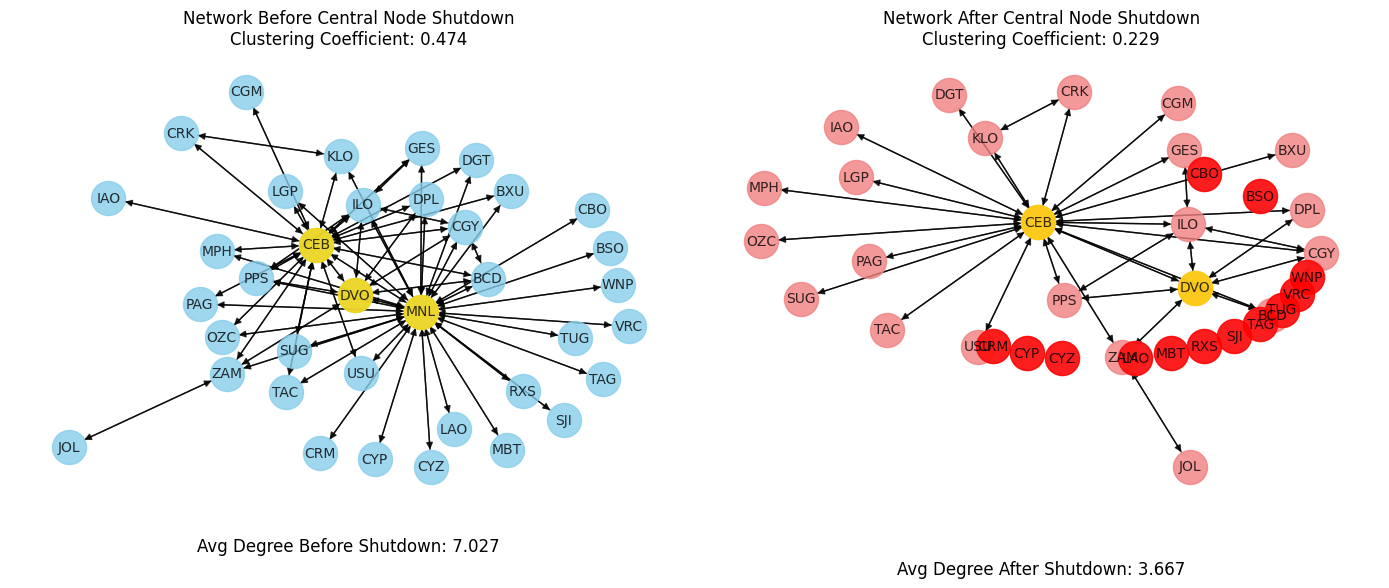

In [308]:
# Set the centrality threshold for central nodes (0.4 in this example)
centrality_threshold = 0.4

# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(graph)

# Filter the nodes based on the centrality threshold
central_nodes = [node for node, centrality in degree_centrality.items() if centrality > centrality_threshold]

# Sort the central nodes by degree centrality in descending order
central_nodes_sorted = sorted(central_nodes, key=lambda node: degree_centrality[node], reverse=True)

# Select the top n central nodes to visualize (e.g., n = 3)
n = 3
top_n_central_nodes = central_nodes_sorted[:n]

# Calculate initial network properties (before shutdown)
initial_average_degree = sum(dict(graph.degree()).values()) / len(graph)
initial_clustering_coefficient = nx.average_clustering(graph)

# Identify the central node to shut down (for this example, let's use the node with the highest degree)
central_node_to_shutdown = max(graph.degree(), key=lambda x: x[1])[0]

# Simulate the shutdown
graph_after_shutdown = graph.copy()
graph_after_shutdown.remove_node(central_node_to_shutdown)

# Calculate network properties after shutdown
after_shutdown_average_degree = sum(dict(graph_after_shutdown.degree()).values()) / len(graph_after_shutdown)
after_shutdown_clustering_coefficient = nx.average_clustering(graph_after_shutdown)

# Visualization
plt.figure(figsize=(14, 6))

# Plot the network before shutdown
plt.subplot(1, 2, 1)
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos=pos, with_labels=True, node_color='skyblue', node_size=600, font_size=10, alpha=0.8)

# Highlight the top n central nodes in red
nx.draw_networkx_nodes(graph, pos, nodelist=top_n_central_nodes, node_color='gold', node_size=600, alpha=0.8)

plt.title(f'Network Before Central Node Shutdown\nClustering Coefficient: {initial_clustering_coefficient:.3f}')

# Display average degree before and after shutdown
plt.text(0.5, -0.1, f'Avg Degree Before Shutdown: {initial_average_degree:.3f}',
         transform=plt.gca().transAxes, fontsize=12, ha='center', color='black')

# Calculate new top_n_central_nodes for the second plot after removing the central node
top_n_central_nodes_after_shutdown = [node for node in top_n_central_nodes if node != central_node_to_shutdown]

# Plot the network after shutdown
plt.subplot(1, 2, 2)
pos_after = nx.kamada_kawai_layout(graph_after_shutdown)
nx.draw(graph_after_shutdown, pos=pos_after, with_labels=True, node_color='lightcoral', node_size=600, font_size=10, alpha=0.8)

# Highlight the top n central nodes in red
nx.draw_networkx_nodes(graph_after_shutdown, pos_after, nodelist=top_n_central_nodes_after_shutdown, node_color='gold', node_size=600, alpha=0.8)

# Find isolated nodes (nodes without any edges)
isolated_nodes = [node for node in graph_after_shutdown.nodes() if graph_after_shutdown.degree(node) == 0]

# Assign a new color (e.g., green) to isolated nodes
nx.draw_networkx_nodes(graph_after_shutdown, pos_after, nodelist=isolated_nodes, node_color='red', node_size=600, alpha=0.8)

plt.text(0.5, -0.15, f'Avg Degree After Shutdown: {after_shutdown_average_degree:.3f}',
         transform=plt.gca().transAxes, fontsize=12, ha='center', color='black')

plt.title(f'Network After Central Node Shutdown\nClustering Coefficient: {after_shutdown_clustering_coefficient:.3f}')

plt.tight_layout()
plt.show()

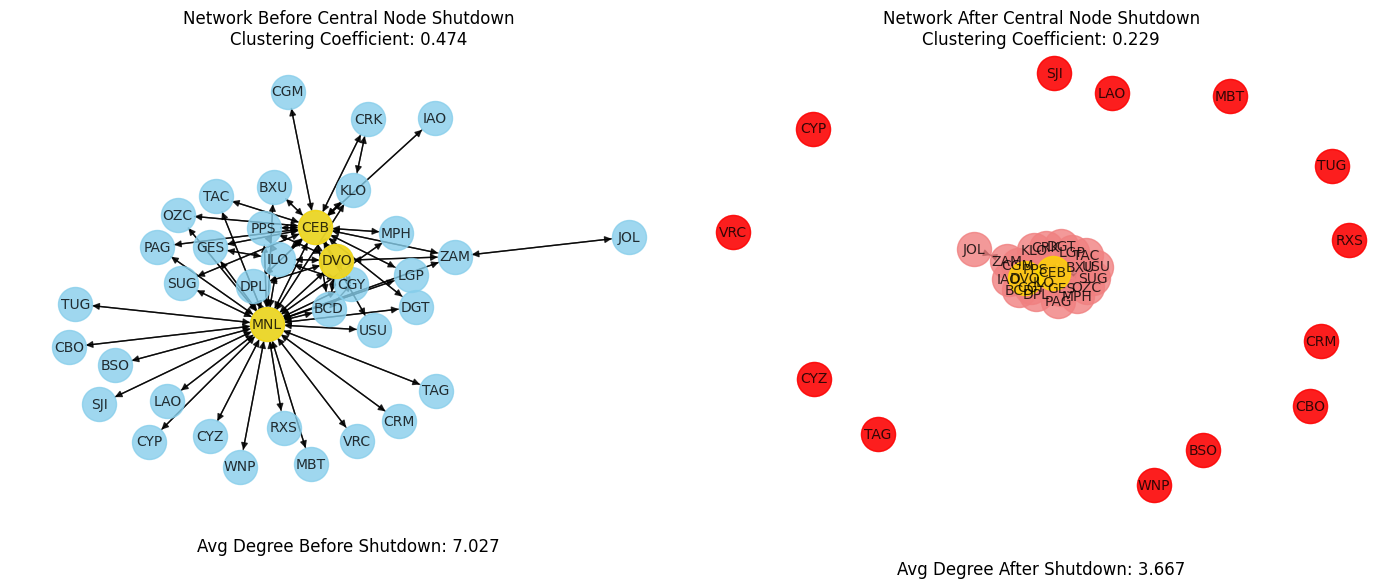

In [310]:
# Set the centrality threshold for central nodes (0.4 in this example)
centrality_threshold = 0.4

# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(graph)

# Filter the nodes based on the centrality threshold
central_nodes = [node for node, centrality in degree_centrality.items() if centrality > centrality_threshold]

# Sort the central nodes by degree centrality in descending order
central_nodes_sorted = sorted(central_nodes, key=lambda node: degree_centrality[node], reverse=True)

# Select the top n central nodes to visualize (e.g., n = 3)
n = 3
top_n_central_nodes = central_nodes_sorted[:n]

# Calculate initial network properties (before shutdown)
initial_average_degree = sum(dict(graph.degree()).values()) / len(graph)
initial_clustering_coefficient = nx.average_clustering(graph)

# Identify the central node to shut down (for this example, let's use the node with the highest degree)
central_node_to_shutdown = max(graph.degree(), key=lambda x: x[1])[0]

# Simulate the shutdown
graph_after_shutdown = graph.copy()
graph_after_shutdown.remove_node(central_node_to_shutdown)

# Calculate network properties after shutdown
after_shutdown_average_degree = sum(dict(graph_after_shutdown.degree()).values()) / len(graph_after_shutdown)
after_shutdown_clustering_coefficient = nx.average_clustering(graph_after_shutdown)

# Visualization
plt.figure(figsize=(14, 6))

# Plot the network before shutdown
plt.subplot(1, 2, 1)
pos = nx.spring_layout(graph)
nx.draw(graph, pos=pos, with_labels=True, node_color='skyblue', node_size=600, font_size=10, alpha=0.8)

# Highlight the top n central nodes in red
nx.draw_networkx_nodes(graph, pos, nodelist=top_n_central_nodes, node_color='gold', node_size=600, alpha=0.8)

plt.title(f'Network Before Central Node Shutdown\nClustering Coefficient: {initial_clustering_coefficient:.3f}')

# Display average degree before and after shutdown
plt.text(0.5, -0.1, f'Avg Degree Before Shutdown: {initial_average_degree:.3f}',
         transform=plt.gca().transAxes, fontsize=12, ha='center', color='black')

# Calculate new top_n_central_nodes for the second plot after removing the central node
top_n_central_nodes_after_shutdown = [node for node in top_n_central_nodes if node != central_node_to_shutdown]

# Plot the network after shutdown
plt.subplot(1, 2, 2)
pos_after = nx.spring_layout(graph_after_shutdown)
nx.draw(graph_after_shutdown, pos=pos_after, with_labels=True, node_color='lightcoral', node_size=600, font_size=10, alpha=0.8)

# Highlight the top n central nodes in red
nx.draw_networkx_nodes(graph_after_shutdown, pos_after, nodelist=top_n_central_nodes_after_shutdown, node_color='gold', node_size=600, alpha=0.8)

# Find isolated nodes (nodes without any edges)
isolated_nodes = [node for node in graph_after_shutdown.nodes() if graph_after_shutdown.degree(node) == 0]

# Assign a new color (e.g., green) to isolated nodes
nx.draw_networkx_nodes(graph_after_shutdown, pos_after, nodelist=isolated_nodes, node_color='red', node_size=600, alpha=0.8)

plt.text(0.5, -0.15, f'Avg Degree After Shutdown: {after_shutdown_average_degree:.3f}',
         transform=plt.gca().transAxes, fontsize=12, ha='center', color='black')

plt.title(f'Network After Central Node Shutdown\nClustering Coefficient: {after_shutdown_clustering_coefficient:.3f}')

plt.tight_layout()
plt.show()

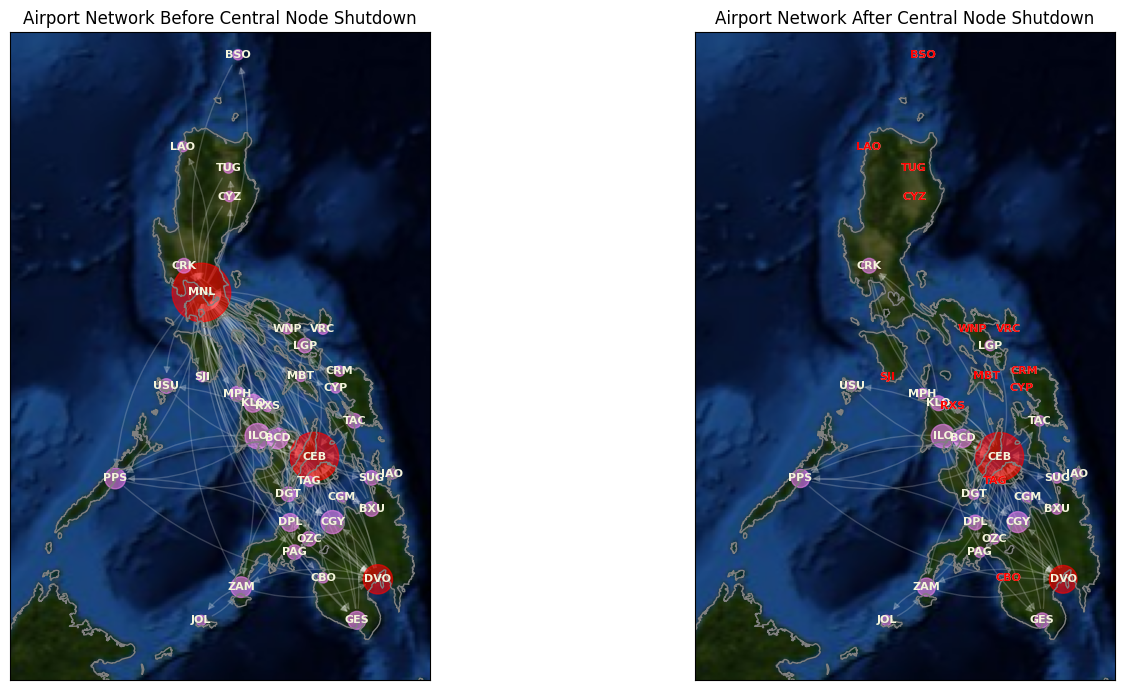

In [331]:
# graph = nx.Graph()

plt.figure(figsize=(16, 7))

# Set the map boundaries to focus on the Philippines region
m = Basemap(
    projection='merc',
    llcrnrlon=116.0,  # Minimum longitude
    llcrnrlat=4.5,    # Minimum latitude
    urcrnrlon=127.0,  # Maximum longitude
    urcrnrlat=21.0,   # Maximum latitude
    lat_ts=0,
    resolution='i',
    suppress_ticks=True
)

mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate(pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

# Calculate the degree centrality of nodes
degree_centrality = nx.degree_centrality(graph)

# Set node sizes based on degree centrality
node_sizes = [degree_centrality[node] * 1000 for node in graph.nodes()]

# Determine the median total_flight value as the cutoff for large and small airports
cutoff = 15

# Assign colors based on the total_flight value
node_colors = ['red' if total_flight >= cutoff else 'violet' for total_flight in
               pos_data.set_index('IATA').reindex(graph.nodes()).reset_index()['total_flight']]

# Plot the network before shutdown
plt.subplot(1, 2, 1)

m.bluemarble()

nx.draw_networkx_nodes(
    G=graph,
    pos=pos,
    nodelist=graph.nodes(),
    node_color=node_colors,
    edgecolors=None,  # White node borders
    alpha=0.6,
    node_size=node_sizes
)

# Draw the edges with curved connections
edges = nx.draw_networkx_edges(
    G=graph,
    pos=pos,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# Add labels to the nodes
labels = {elem: elem for elem in graph.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph,
    pos=pos,
    labels=labels,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

# Customize the map colors
m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

plt.title('Airport Network Before Central Node Shutdown')

# Simulate the shutdown
graph_after_shutdown = graph.copy()
graph_after_shutdown.remove_node(central_node_to_shutdown)

# Calculate the degree centrality of nodes after shutdown
degree_centrality_after_shutdown = nx.degree_centrality(graph_after_shutdown)

# Set node sizes based on degree centrality after shutdown
node_sizes_after_shutdown = [degree_centrality_after_shutdown[node] * 1000 for node in graph_after_shutdown.nodes()]

# Plot the network after shutdown
plt.subplot(1, 2, 2)

m.bluemarble()

# Calculate the positions for nodes after shutdown
mx_after, my_after = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos_after = {}
for count, elem in enumerate(pos_data['IATA']):
    if elem in graph_after_shutdown.nodes():
        pos_after[elem] = (mx_after[count], my_after[count])

node_color_after_shutdown = ['red' if degree_centrality[node] > 0.4 else 'violet' for node in graph_after_shutdown.nodes()]

nx.draw_networkx_nodes(
    G=graph_after_shutdown,
    pos=pos_after,
    nodelist=graph_after_shutdown.nodes(),
    node_color=node_color_after_shutdown,
    edgecolors=None,  # White node borders
    alpha=0.6,
    node_size=node_sizes_after_shutdown  # Use node sizes after shutdown
)

# Draw the edges with curved connections
edges_after_shutdown = nx.draw_networkx_edges(
    G=graph_after_shutdown,
    pos=pos_after,
    edge_color='w',
    alpha=0.2,
    arrows=True,
    connectionstyle='arc3,rad=0.2'  # Adjust the curvature by changing the 'rad' value
)

# Add labels to the nodes after shutdown
labels_after_shutdown = {elem: elem for elem in graph_after_shutdown.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph_after_shutdown,
    pos=pos_after,
    labels=labels_after_shutdown,
    font_size=8,
    font_color='beige',
    font_weight='bold',
)

isolated_nodes_labels = {node: node for node in graph_after_shutdown.nodes() if graph_after_shutdown.degree(node) == 0}

# Add labels to the nodes after shutdown
labels_after_shutdown = {elem: elem for elem in graph_after_shutdown.nodes()}  # Use the airport IATA codes as labels
nx.draw_networkx_labels(
    G=graph_after_shutdown,
    pos=pos_after,
    labels=isolated_nodes_labels,
    font_size=8,
    font_color='red',
    font_weight='bold',
)

# Customize the map colors
m.drawcountries(linewidth=1, color='gray')  # Gray country borders
m.drawstates(linewidth=0.2, color='black')  # Gray state borders
m.drawcoastlines(linewidth=1, color='gray')  # Gray coastlines

plt.title('Airport Network After Central Node Shutdown')

plt.tight_layout()
plt.show()
